In [2]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from glob import glob
import itertools
import warnings
from importlib import reload
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 30
pd.options.display.max_columns = 999

# Stats
from sklearn.utils.fixes import loguniform
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
# from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import helper_funcs
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, pop_decoding

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [3]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0]
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*-Events.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [4]:
# Get spike counts in each time bin, for all neurons in the study.
pop_spikes = pop_decoding.load_pop_spikes()

# Working

In [34]:
reload(pop_decoding)

<module 'time_cells.pop_decoding' from '/home1/dscho/code/projects/time_cells/pop_decoding.py'>

In [36]:
def classify_within_subj_parallel(kws):
    import sys
    sys.path.append('/home1/dscho/code/projects')
    from time_cells import pop_decoding
    
    try:
        clf_results = pop_decoding.classify_within_subj(**kws)
    except:
        errf = '/home1/dscho/logs/TryExceptError-classify_within_subj_parallel-{}'.format(kws.get('subj_sess', '?'))
        with open(errf, 'w') as _f:
            _f.write(str(sys.exc_info()) + '\n')

In [ ]:
# Get sessions to process.
y_col = 'maze_region'
game_states = ['Encoding', 'Retrieval']
save_clfs = True
overwrite = True

fpath = op.join(proj_dir, 'analysis', 'classifiers',
                'SVC_predicting_{}-{}-*-{}-*.pkl')
sessions_to_process = []
for subj_sess in ['U537_ses0', 'U539_ses0']:
    for game_state in game_states:
        if len(glob(fpath.format(y_col, subj_sess, game_state))) == 0:
            sessions_to_process.append({'subj_sess': subj_sess,
                                        'y_col': y_col,
                                        'game_states': [game_state],
                                        'save_clfs': save_clfs,
                                        'overwrite': overwrite})
print('{} sessions to process'.format(len(sessions_to_process)))

# Parallel processing
if len(sessions_to_process) > 0:
    n_ops = len(sessions_to_process)
    print('Running code for {} operations.\n'.format(n_ops))
    with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=np.min((n_ops, 100)), cores_per_job=1) as view:
        output = view.map(classify_within_subj_parallel, sessions_to_process)

4 sessions to process
Running code for 4 operations.

4 Engines running


In [ ]:
# Get sessions to process.
y_col = 'time_bin'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
save_clfs = True
overwrite = True

fpath = op.join(proj_dir, 'analysis', 'classifiers',
                'SVC_predicting_time_bin-{}-*-{}-*.pkl')
sessions_to_process = []
for subj_sess in sessions:
    for game_state in game_states:
        if len(glob(fpath.format(subj_sess, game_state))) == 0:
            sessions_to_process.append({'subj_sess': subj_sess,
                                        'y_col': y_col,
                                        'game_states': [game_state],
                                        'save_clfs': save_clfs,
                                        'overwrite': overwrite})
print('{} sessions to process'.format(len(sessions_to_process)))

# Parallel processing
n_ops = len(sessions_to_process)
print('Running code for {} operations.\n'.format(n_ops))
with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=np.min((n_ops, 100)), cores_per_job=1) as view:
    output = view.map(classify_within_subj_parallel, sessions_to_process)

48 sessions to process
Running code for 48 operations.

48 Engines running


In [26]:
sessions_to_process[0]

{'subj_sess': 'U518_ses0',
 'y_col': 'time_bin',
 'game_states': ['Delay1'],
 'save_clfs': True,
 'overwrite': True}

# Start

In [ ]:
# Train classifiers to predict time in each game state,
# using all neurons and saving the output classifiers.
game_states = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
# time_steps_per_game_state={'Delay1': 10, 'Encoding': 30, 'Delay2': 10, 'Retrieval': 30}
time_steps_per_game_state={'Delay1': 5, 'Encoding': 15, 'Delay2': 5, 'Retrieval': 15}
drop_first2 = False
save_results = True
overwrite = True
verbose = True

start_time = time()

clf_results = pop_decoding.classify_time(game_states=game_states,
                                         time_steps_per_game_state=time_steps_per_game_state,
                                         drop_first2=drop_first2,
                                         save_clfs=True,
                                         proj_dir=proj_dir,
                                         save_results=save_results,
                                         overwrite=overwrite,
                                         verbose=verbose)

print('Done in {:.1f} min'.format((time() - start_time) / 60))

In [2]:
def plot_embedding(df,
                   x,
                   y,
                   hue=None,
                   size=None,
                   **kws):
    # Min-max scale X.
    df[[x, y]] = minmax_scale(df[[x, y]].values, axis=0)
    
    # Plot params.
    colws = kws.pop('colws', {1: 2.05, 2: 3.125, 3: 6.45})
    figsize = (colws[2], colws[2] * 1)
    dpi = kws.pop('dpi', 600)
    font = kws.pop('font', {'tick': 8, 'label': 10, 'annot': 8, 'fig': 12})
    if hue is None:
        _cmap = None
    else:
        n_cats = np.unique(df[hue]).size
        if n_cats == 8:
            _cmap = [sns.color_palette('Blues')[4],
                     sns.color_palette('Reds')[5],
                     sns.color_palette('Reds')[3],
                     sns.color_palette('Reds')[1],
                     sns.color_palette('Greens')[4],
                     sns.color_palette('Purples')[5],
                     sns.color_palette('Purples')[3],
                     sns.color_palette('Purples')[1]]
        else:
            _cmap = [sns.color_palette('Blues')[5],
                     sns.color_palette('Blues')[1],
                     sns.color_palette('Reds')[5],
                     sns.color_palette('Reds')[3],
                     sns.color_palette('Reds')[1],
                     sns.color_palette('Greens')[5],
                     sns.color_palette('Greens')[1],
                     sns.color_palette('Purples')[5],
                     sns.color_palette('Purples')[3],
                     sns.color_palette('Purples')[1]]
    
    # Make the plot.
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    
    ax = sns.scatterplot(x=x, y=y, hue=hue, size=size, data=df, ax=ax,
                         palette=_cmap, alpha=0.8, linewidth=0.4, edgecolor='k')
    ax.set_aspect('equal')
    ax.tick_params(labelsize=font['tick'], length=2, width=0.8, pad=2, color='k')
    ax.set_xlim([-0.05, 1.05])
    xticks = [0, 0.25, 0.5, 0.75, 1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlabel('')
    ax.set_ylim(ax.get_xlim())
    ax.set_yticks(ax.get_xticks())
    ax.set_yticklabels(ax.get_xticklabels())
    ax.set_ylabel(ax.get_xlabel())
    legend = ax.legend(loc=1, fontsize=font['annot'], handletextpad=0, bbox_to_anchor=[1.5, 1])
    
    return fig, ax

def plot_embedding_3d(df,
                      x,
                      y,
                      z,
                      hue=None,
                      **kws):
    # Min-max scale X.
    df[[x, y, z]] = minmax_scale(df[[x, y, z]].values, axis=0)
    
    # Plot params.
    colws = kws.pop('colws', {1: 2.05, 2: 3.125, 3: 6.45})
    figsize = (colws[2], colws[2] * 1)
    dpi = kws.pop('dpi', 600)
    font = kws.pop('font', {'tick': 8, 'label': 10, 'annot': 8, 'fig': 12})
    _cmap = od([('Delay 1:  0-10s', sns.color_palette('Blues')[4],),
                ('Encoding:  0-10s', sns.color_palette('Reds')[5]),
                ('Encoding: 10-20s', sns.color_palette('Reds')[3]),
                ('Encoding: 20-30s', sns.color_palette('Reds')[1]),
                ('Delay 2:  0-10s', sns.color_palette('Greens')[4]),
                ('Retrieval:  0-10s', sns.color_palette('Purples')[5]),
                ('Retrieval: 10-20s', sns.color_palette('Purples')[3]),
                ('Retrieval: 20-30s', sns.color_palette('Purples')[1])])
    colors = np.array([_cmap[x] for x in df['gameStateTime']])
    
    # Make the plot.
    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(df[x], df[y], df[z], c=colors, data=df,
               linewidth=0.4, edgecolor='k')
    ax.set_aspect('equal')
    ax.tick_params(labelsize=font['tick'], length=2, width=0.8, pad=2, color='k')
    ax.set_xlim([-0.05, 1.05])
    xticks = [0, 0.25, 0.5, 0.75, 1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlabel('')
    ax.set_ylim(ax.get_xlim())
    ax.set_yticks(ax.get_xticks())
    ax.set_yticklabels(ax.get_xticklabels())
    ax.set_ylabel(ax.get_xlabel())
    ax.set_zlim(ax.get_xlim())
    ax.set_zticks(ax.get_xticks())
    ax.set_zticklabels(ax.get_xticklabels())
    ax.set_zlabel(ax.get_xlabel())
    #legend = ax.legend(loc=1, fontsize=font['annot'], handletextpad=0, bbox_to_anchor=[1.5, 1])
    
    return fig, ax

In [670]:
# # Get spike counts in each time bin, for all neurons in the study.
# start_time = time()

# game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
# behav_cols = ['trial', 'gameState', 'time_bin']

# neurons = []
# dfs = od([])
# for subj_sess in sessions:
#     event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
#     neuron_labels = od({neuron: '{}-{}'.format(subj_sess, neuron) 
#                         for neuron in event_spikes.column_map['neurons']})
#     dfs[subj_sess] = (event_spikes.event_spikes.query("(gameState=={})".format(game_states))
#                                                .rename(columns=neuron_labels)
#                                                .loc[:, behav_cols + list(neuron_labels.values())]
#                                                .set_index(behav_cols))
#     neurons += list(neuron_labels.values())

# pop_spikes = pd.concat(dfs, axis=1)
# pop_spikes.columns = pop_spikes.columns.get_level_values(1)
# pop_spikes = pop_spikes.reset_index()

# # Sort rows.
# game_state_cat = pd.CategoricalDtype(game_states, ordered=True)
# pop_spikes['gameState'] = pop_spikes['gameState'].astype(game_state_cat)
# pop_spikes = pop_spikes.sort_values(['trial', 'gameState', 'time_bin']).reset_index(drop=True)
# del dfs

# # # Impute missing data by replacing NaNs with their column-wise means.
# # pop_spikes[neurons] = pop_spikes[neurons].fillna(pop_spikes[neurons].mean(axis=0), axis=0)

# print('{} neurons'.format(len(neurons)))
# print('pop_spikes: {}'.format(pop_spikes.shape))
# print('Done in {:.1f}s'.format(time() - start_time))

# 2D LDA

In [5]:
# Select a subset of pop_spikes rows.
game_state = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
_pop_spikes = pop_spikes.query("(gameState=={})".format(game_state)).reset_index(drop=True).copy()

# Add a column for even/odd trials.
_pop_spikes.insert(1, 'is_odd', _pop_spikes['trial'].apply(lambda x: x % 2 != 0))

# Add a column for time step, and drop time bin.
_pop_spikes.insert(4, 'time_step', _pop_spikes['time_bin'].apply(lambda x: int(x/20)))
_pop_spikes.drop(columns=['time_bin'], inplace=True)

# Aggregate the spiking data.
_pop_spikes = _pop_spikes.groupby(['is_odd', 'trial', 'gameState', 'time_step'], observed=True).mean().reset_index()

# Z-score the firing rates for each unit.
_means = _pop_spikes.loc[_pop_spikes['is_odd']==True, neurons].mean()
_stds = _pop_spikes.loc[_pop_spikes['is_odd']==True, neurons].std()
for is_odd in [True, False]:
    _pop_spikes.loc[_pop_spikes['is_odd']==is_odd, neurons] = (_pop_spikes.loc[_pop_spikes['is_odd']==is_odd, neurons] - _means) / _stds

# Add a column combining game state and time step.
_pop_spikes.insert(2,
                   'gameStateTime',
                   _pop_spikes.apply(lambda x: '{}: {:>2}-{:<2}s'.format(x['gameState'].replace('Delay', 'Delay '),
                                                                         10 * x['time_step'],
                                                                         10 * (x['time_step']+1)), axis=1))

trial_cats = ['Delay 1:  0-10s',
              'Encoding:  0-10s',
              'Encoding: 10-20s',
              'Encoding: 20-30s',
              'Delay 2:  0-10s',
              'Retrieval:  0-10s',
              'Retrieval: 10-20s',
              'Retrieval: 20-30s']
_pop_spikes['gameStateTime'] = _pop_spikes['gameStateTime'].astype(pd.CategoricalDtype(trial_cats, ordered=True))

print('_pop_spikes: {}'.format(_pop_spikes.shape))

AttributeError: 'PopSpikes' object has no attribute 'query'

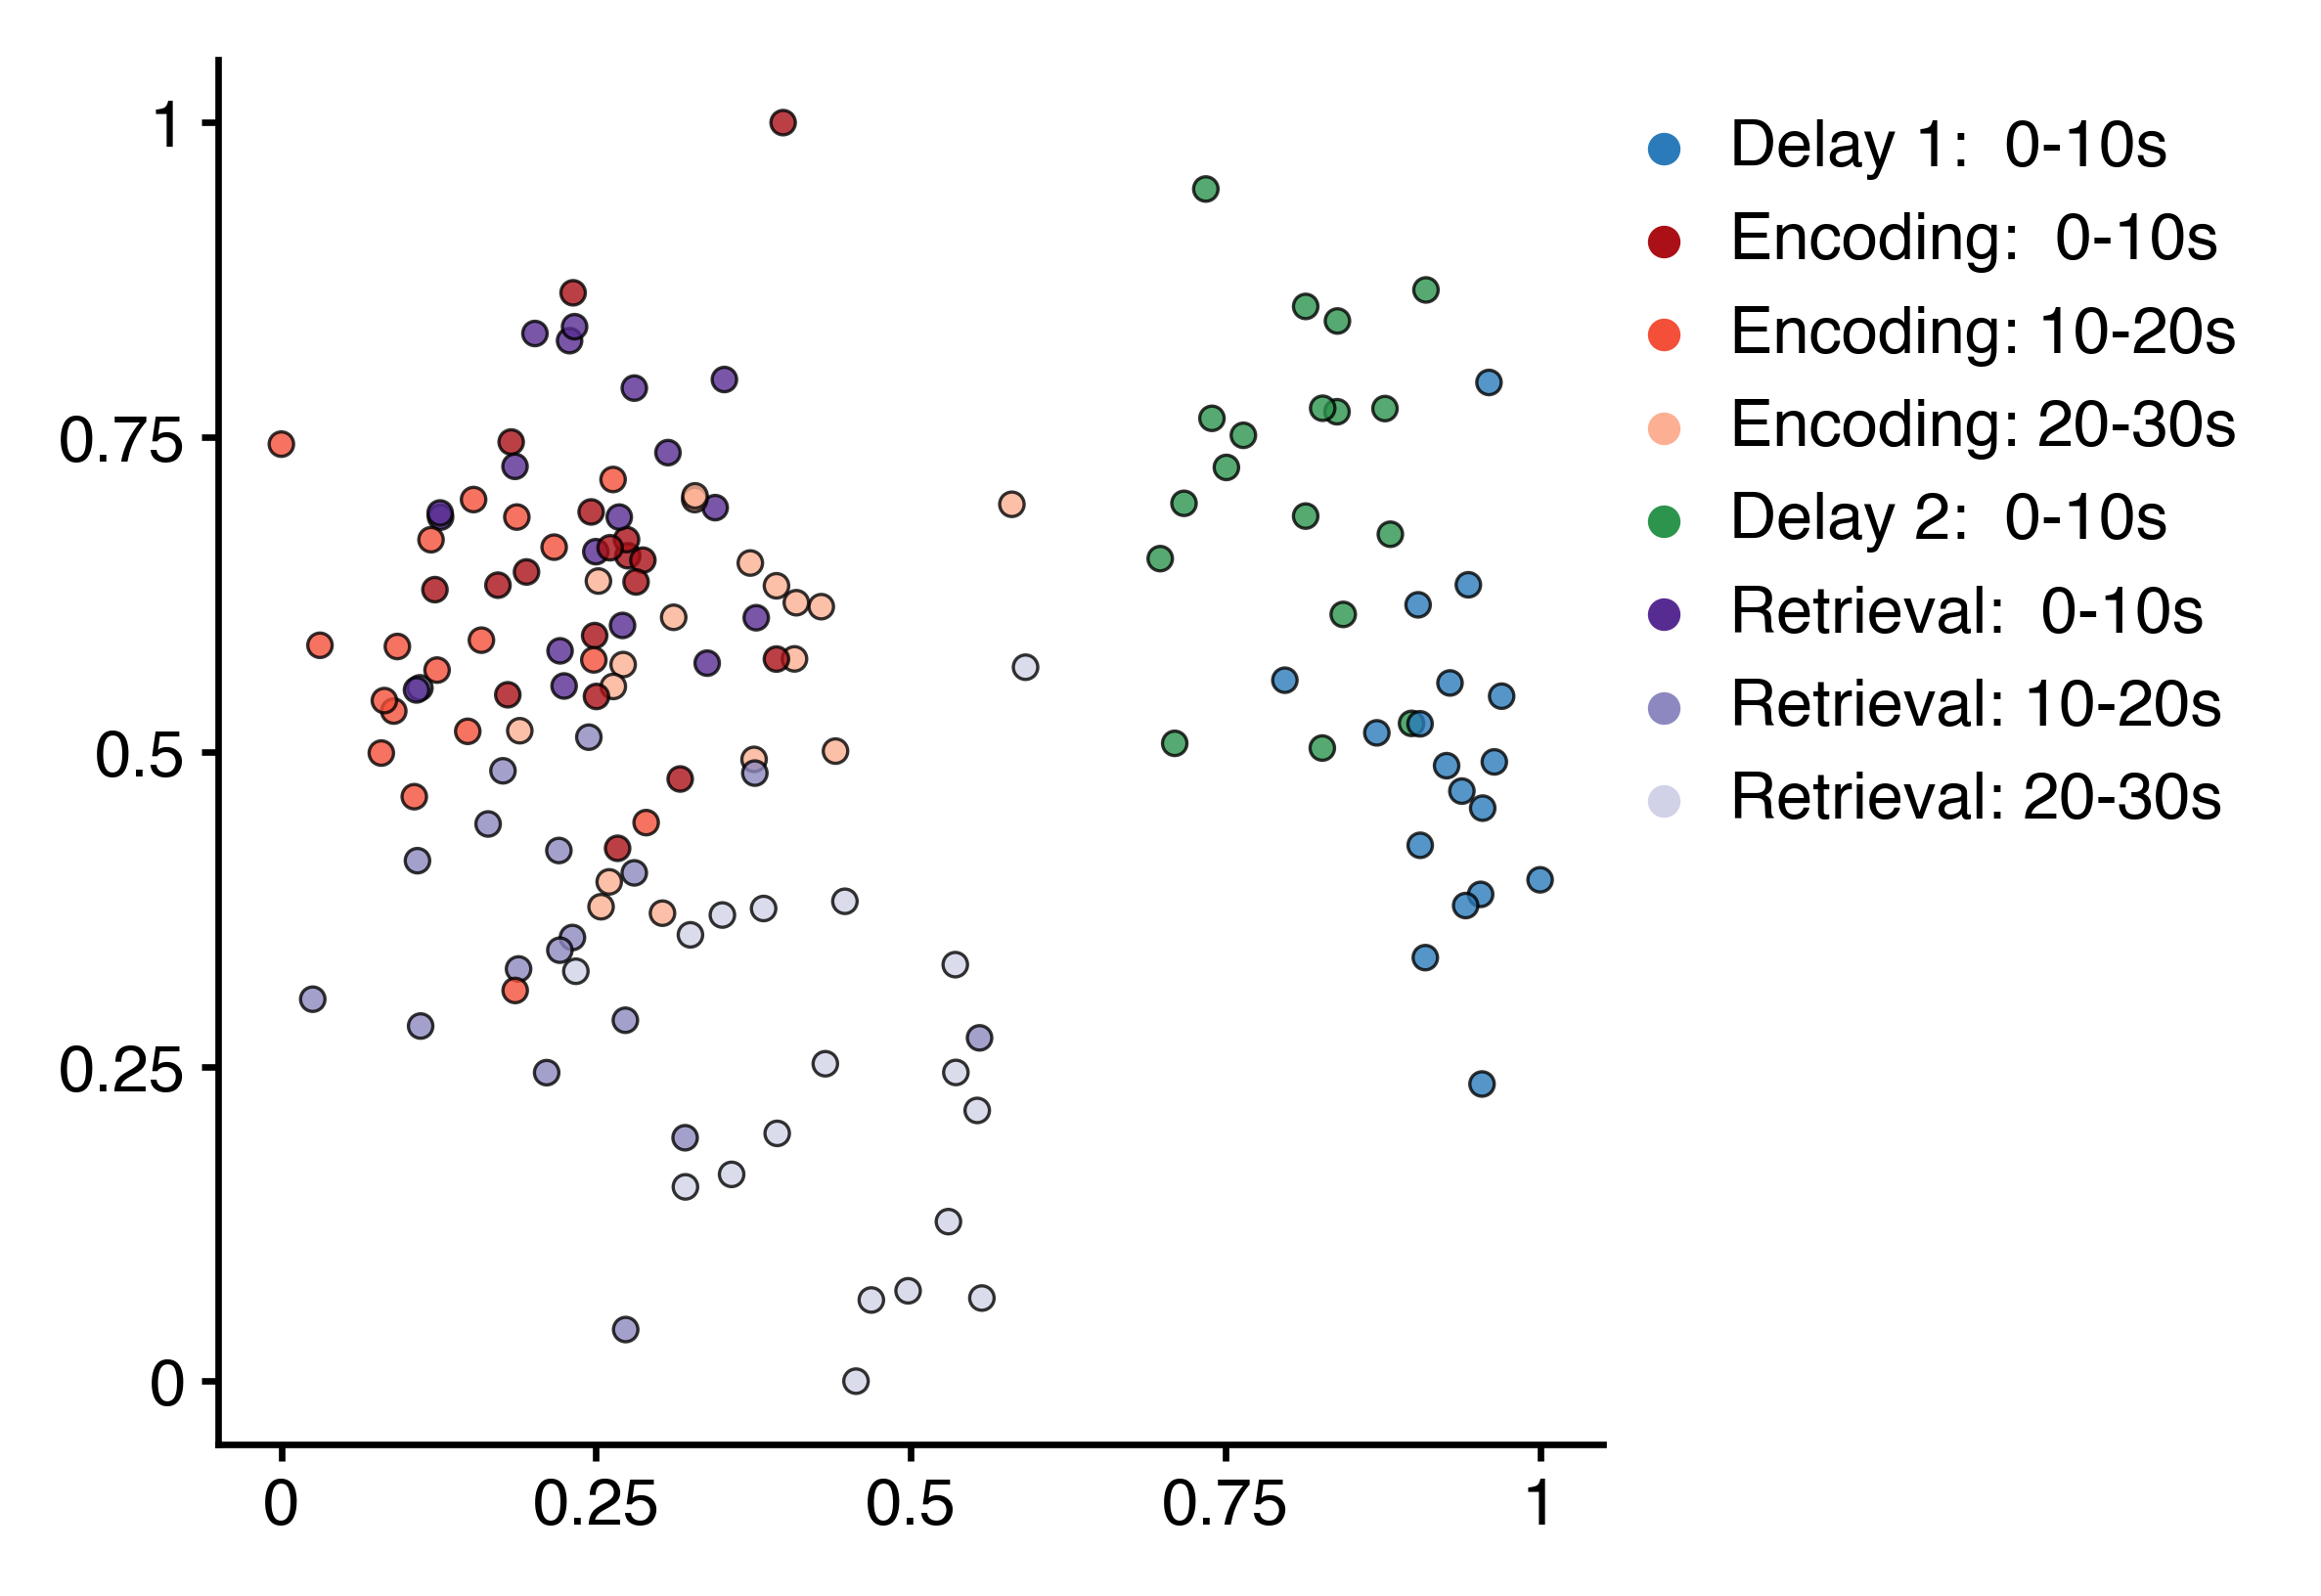

In [74]:
# Project population neural firing onto the first 2 linear discriminant components.
yvar = 'gameStateTime'

# Select the training and test data.
odd_idx = _pop_spikes.query("(is_odd==True)").index.tolist()
even_idx = _pop_spikes.query("(is_odd!=True)").index.tolist()
X_odd = _pop_spikes.loc[odd_idx, neurons].values.copy()
y_odd = _pop_spikes.loc[odd_idx, yvar].values.copy()
X_even = _pop_spikes.loc[even_idx, neurons].values.copy()
y_even = _pop_spikes.loc[even_idx, yvar].values.copy()

# Train the classifier on odd trials.
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=2)
X_odd_lda = lda.fit_transform(X_odd, y_odd)

# Fit the classifier on even trials.
X_even_lda = lda.transform(X_even)

# Add LDA columns to the dataframe.
_pop_spikes['c1'] = np.nan
_pop_spikes['c2'] = np.nan
_pop_spikes.loc[odd_idx, 'c1'] = X_odd_lda[:, 0]
_pop_spikes.loc[odd_idx, 'c2'] = X_odd_lda[:, 1]
_pop_spikes.loc[even_idx, 'c1'] = X_even_lda[:, 0]
_pop_spikes.loc[even_idx, 'c2'] = X_even_lda[:, 1]

# Plot the results.
# plt.close()
# fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=600)
plot_embedding(_pop_spikes.loc[even_idx, :], 'c1', 'c2', hue=yvar)

fig.tight_layout()
fig.show()

In [71]:
# Select a subset of pop_spikes rows.
game_state = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
_pop_spikes = pop_spikes.query("(gameState=={})".format(game_state)).reset_index(drop=True).copy()

# Add a column for even/odd trials.
_pop_spikes.insert(1, 'is_odd', _pop_spikes['trial'].apply(lambda x: x % 2 != 0))

# Add a column for time step, and drop time bin.
_pop_spikes.insert(4, 'time_step', np.nan)
delay_idx = _pop_spikes.loc[np.isin(_pop_spikes['gameState'], ['Delay1', 'Delay2']), :].index.tolist()
nav_idx = _pop_spikes.loc[np.isin(_pop_spikes['gameState'], ['Encoding', 'Retrieval']), :].index.tolist()
_pop_spikes.loc[delay_idx, 'time_step'] = _pop_spikes.loc[delay_idx, 'time_bin'].apply(lambda x: int(x/10))
_pop_spikes.loc[nav_idx, 'time_step'] = _pop_spikes.loc[nav_idx, 'time_bin'].apply(lambda x: int(x/20))
_pop_spikes.drop(columns=['time_bin'], inplace=True)

# Aggregate the spiking data.
_pop_spikes = _pop_spikes.groupby(['is_odd', 'trial', 'gameState', 'time_step'], observed=True).mean().reset_index()

# Z-score the firing rates for each unit.
_means = _pop_spikes.loc[_pop_spikes['is_odd']==True, neurons].mean()
_stds = _pop_spikes.loc[_pop_spikes['is_odd']==True, neurons].std()
for is_odd in [True, False]:
    _pop_spikes.loc[_pop_spikes['is_odd']==is_odd, neurons] = (_pop_spikes.loc[_pop_spikes['is_odd']==is_odd, neurons] - _means) / _stds

# Add a column combining game state and time step.
def _f(x):
    game_state = x['gameState'].replace('Delay', 'Delay ')
    if game_state[:5] == 'Delay':
        mult = 5
    else:
        mult = 10    
    start = int(mult * x['time_step'])
    stop = int(mult * (x['time_step']+1))
    return '{}: {}-{}s'.format(game_state, start, stop)

_pop_spikes.insert(2, 'gameStateTime', np.nan)
delay_idx = _pop_spikes.loc[np.isin(_pop_spikes['gameState'], ['Delay1', 'Delay2']), :].index.tolist()
nav_idx = _pop_spikes.loc[np.isin(_pop_spikes['gameState'], ['Encoding', 'Retrieval']), :].index.tolist()
_pop_spikes.loc[delay_idx, 'gameStateTime'] = _pop_spikes.loc[delay_idx, :].apply(lambda x: _f(x), axis=1)
_pop_spikes.loc[nav_idx, 'gameStateTime'] = _pop_spikes.loc[nav_idx, :].apply(lambda x: _f(x), axis=1)

trial_cats = ['Delay 1: 0-5s',
              'Delay 1: 5-10s',
              'Encoding: 0-10s',
              'Encoding: 10-20s',
              'Encoding: 20-30s',
              'Delay 2: 0-5s',
              'Delay 2: 5-10s',
              'Retrieval: 0-10s',
              'Retrieval: 10-20s',
              'Retrieval: 20-30s']
_pop_spikes['gameStateTime'] = _pop_spikes['gameStateTime'].astype(pd.CategoricalDtype(trial_cats, ordered=True))

print('_pop_spikes: {}'.format(_pop_spikes.shape))

_pop_spikes: (360, 339)


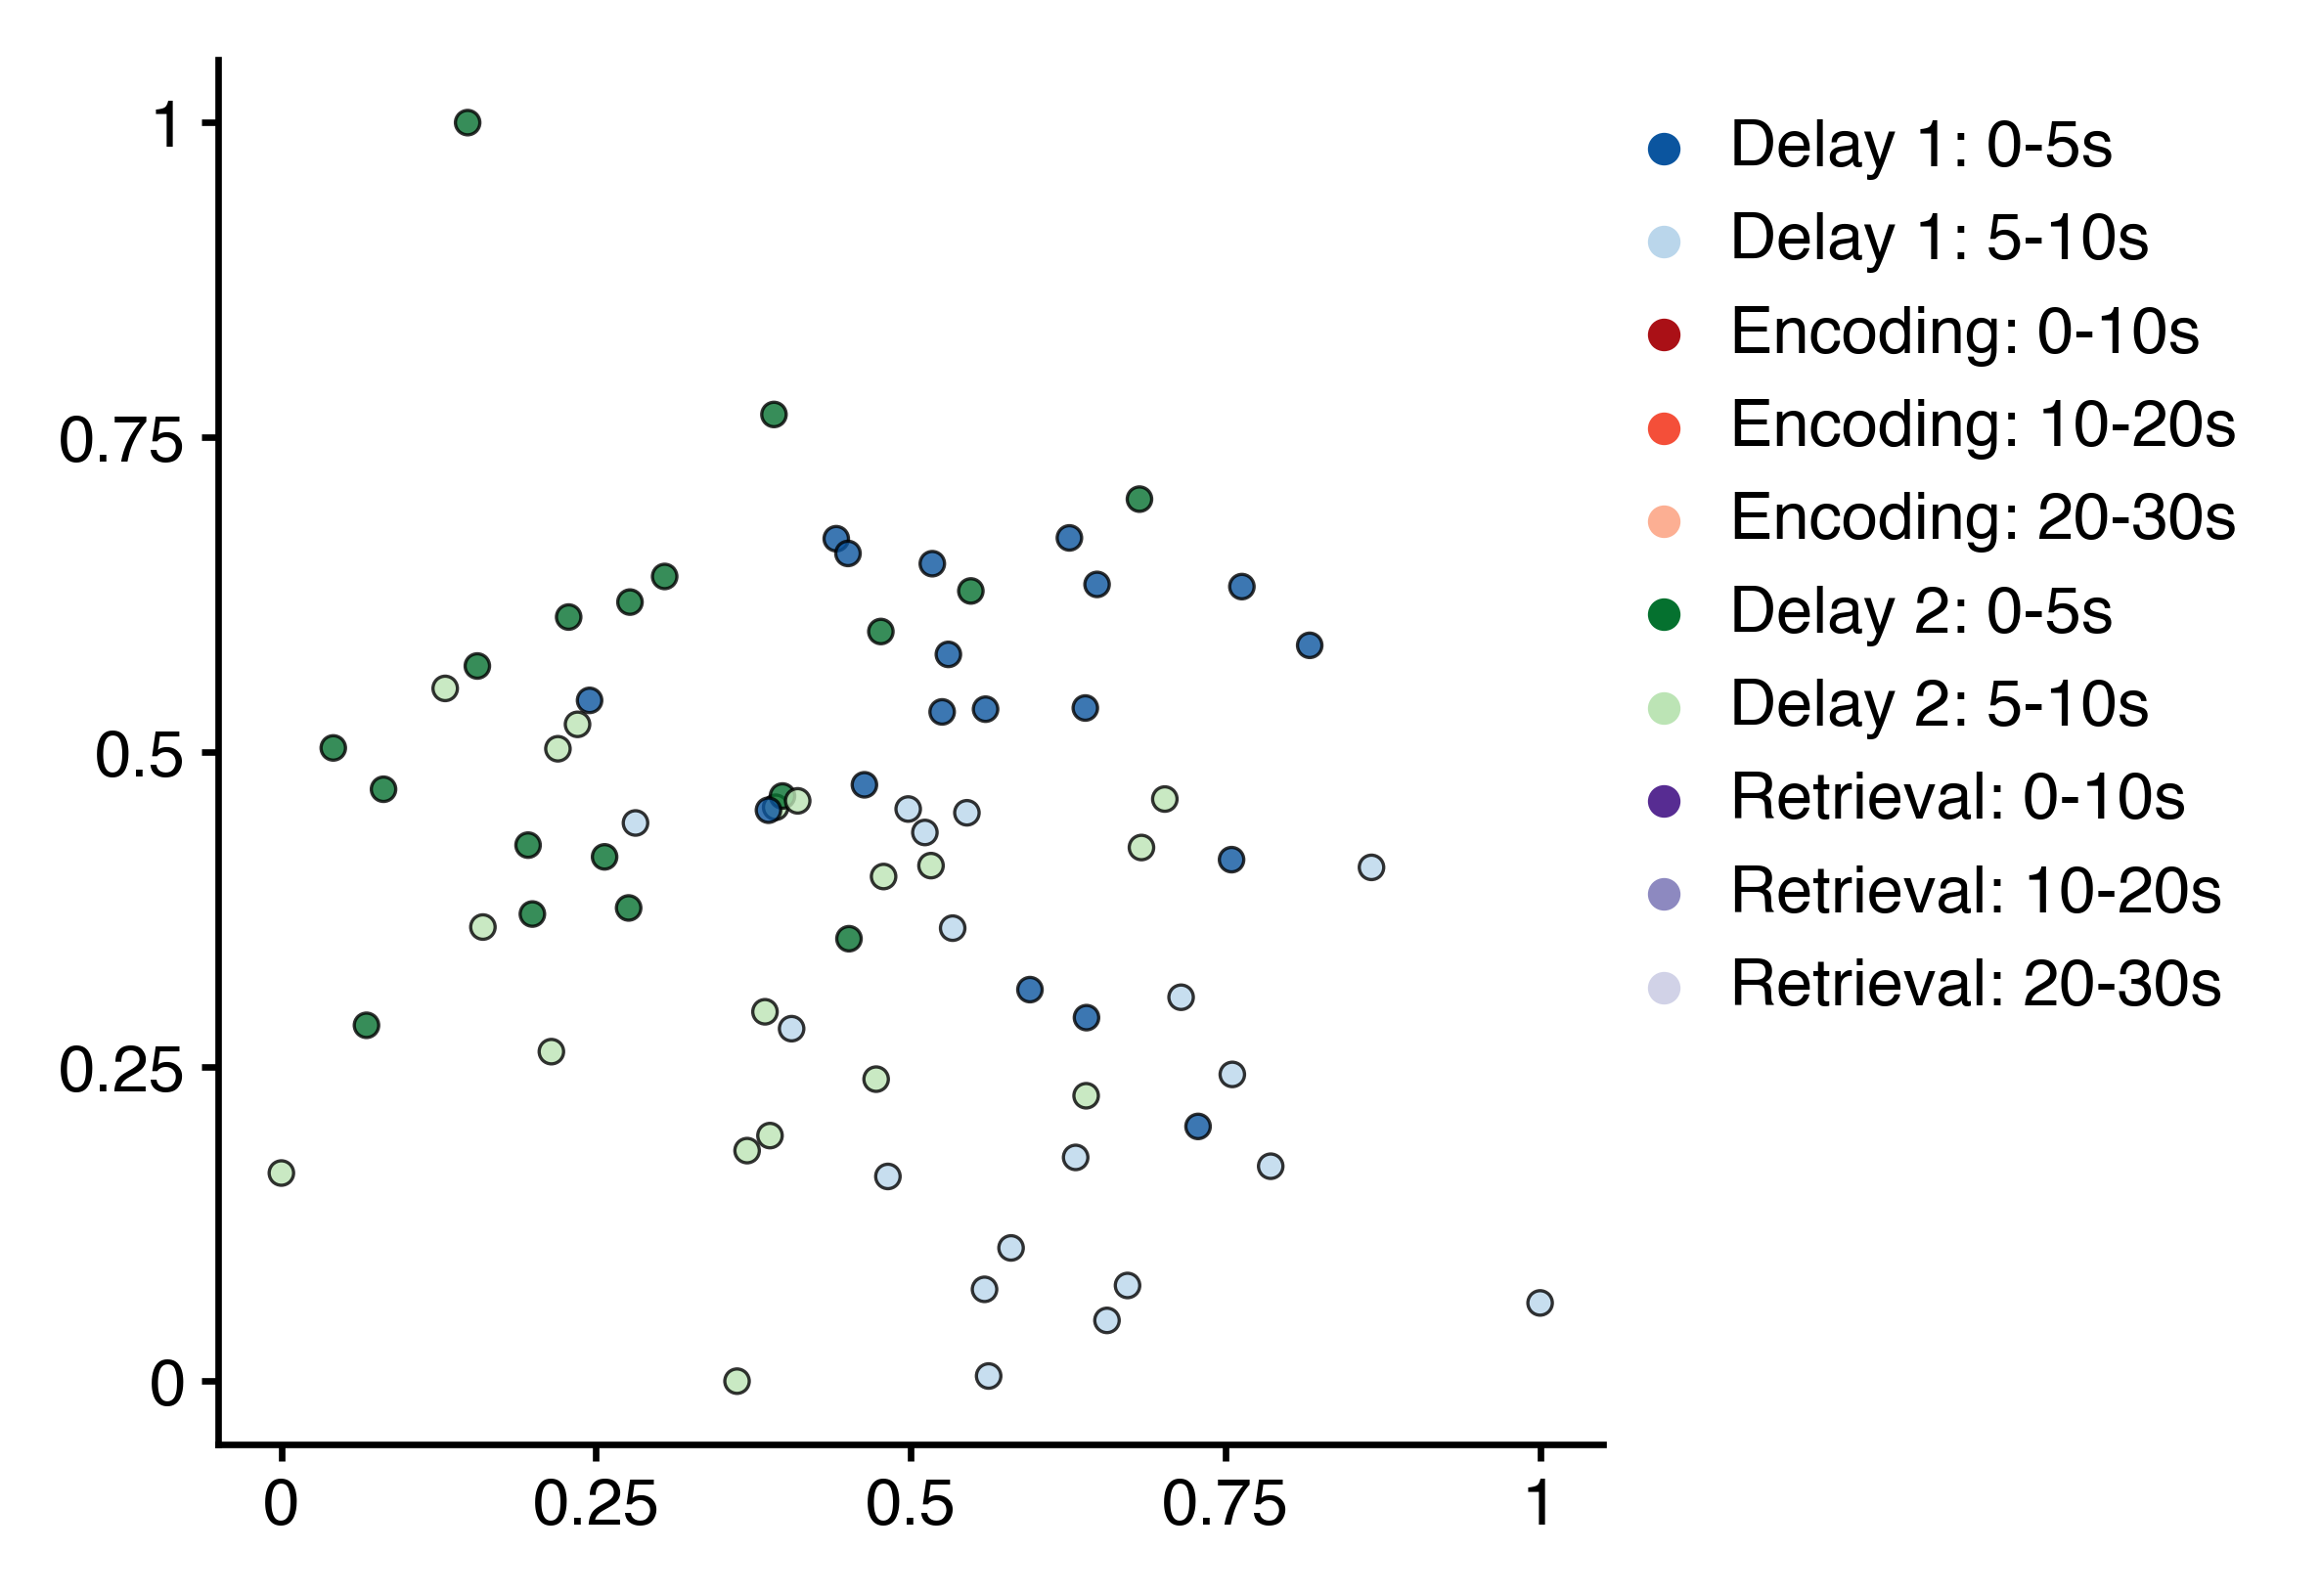

In [68]:
# Project population neural firing onto the first 2 linear discriminant components.
yvar = 'gameStateTime'

_pop_spikes = _pop_spikes.loc[np.isin(_pop_spikes['gameState'], ['Delay1', 'Delay2'])].reset_index(drop=True)

# Select the training and test data.
odd_idx = _pop_spikes.query("(is_odd==True)").index.tolist()
even_idx = _pop_spikes.query("(is_odd!=True)").index.tolist()
X_odd = _pop_spikes.loc[odd_idx, neurons].values.copy()
y_odd = _pop_spikes.loc[odd_idx, yvar].values.copy()
X_even = _pop_spikes.loc[even_idx, neurons].values.copy()
y_even = _pop_spikes.loc[even_idx, yvar].values.copy()

# Train the classifier on odd trials.
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=2)
X_odd_lda = lda.fit_transform(X_odd, y_odd)

# Fit the classifier on even trials.
X_even_lda = lda.transform(X_even)

# Add LDA columns to the dataframe.
_pop_spikes['c1'] = np.nan
_pop_spikes['c2'] = np.nan
_pop_spikes.loc[odd_idx, 'c1'] = X_odd_lda[:, 0]
_pop_spikes.loc[odd_idx, 'c2'] = X_odd_lda[:, 1]
_pop_spikes.loc[even_idx, 'c1'] = X_even_lda[:, 0]
_pop_spikes.loc[even_idx, 'c2'] = X_even_lda[:, 1]

# Plot the results.
# plt.close()
# fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=600)
plot_embedding(_pop_spikes.loc[even_idx, :], 'c1', 'c2', hue=yvar)

fig.tight_layout()
fig.show()

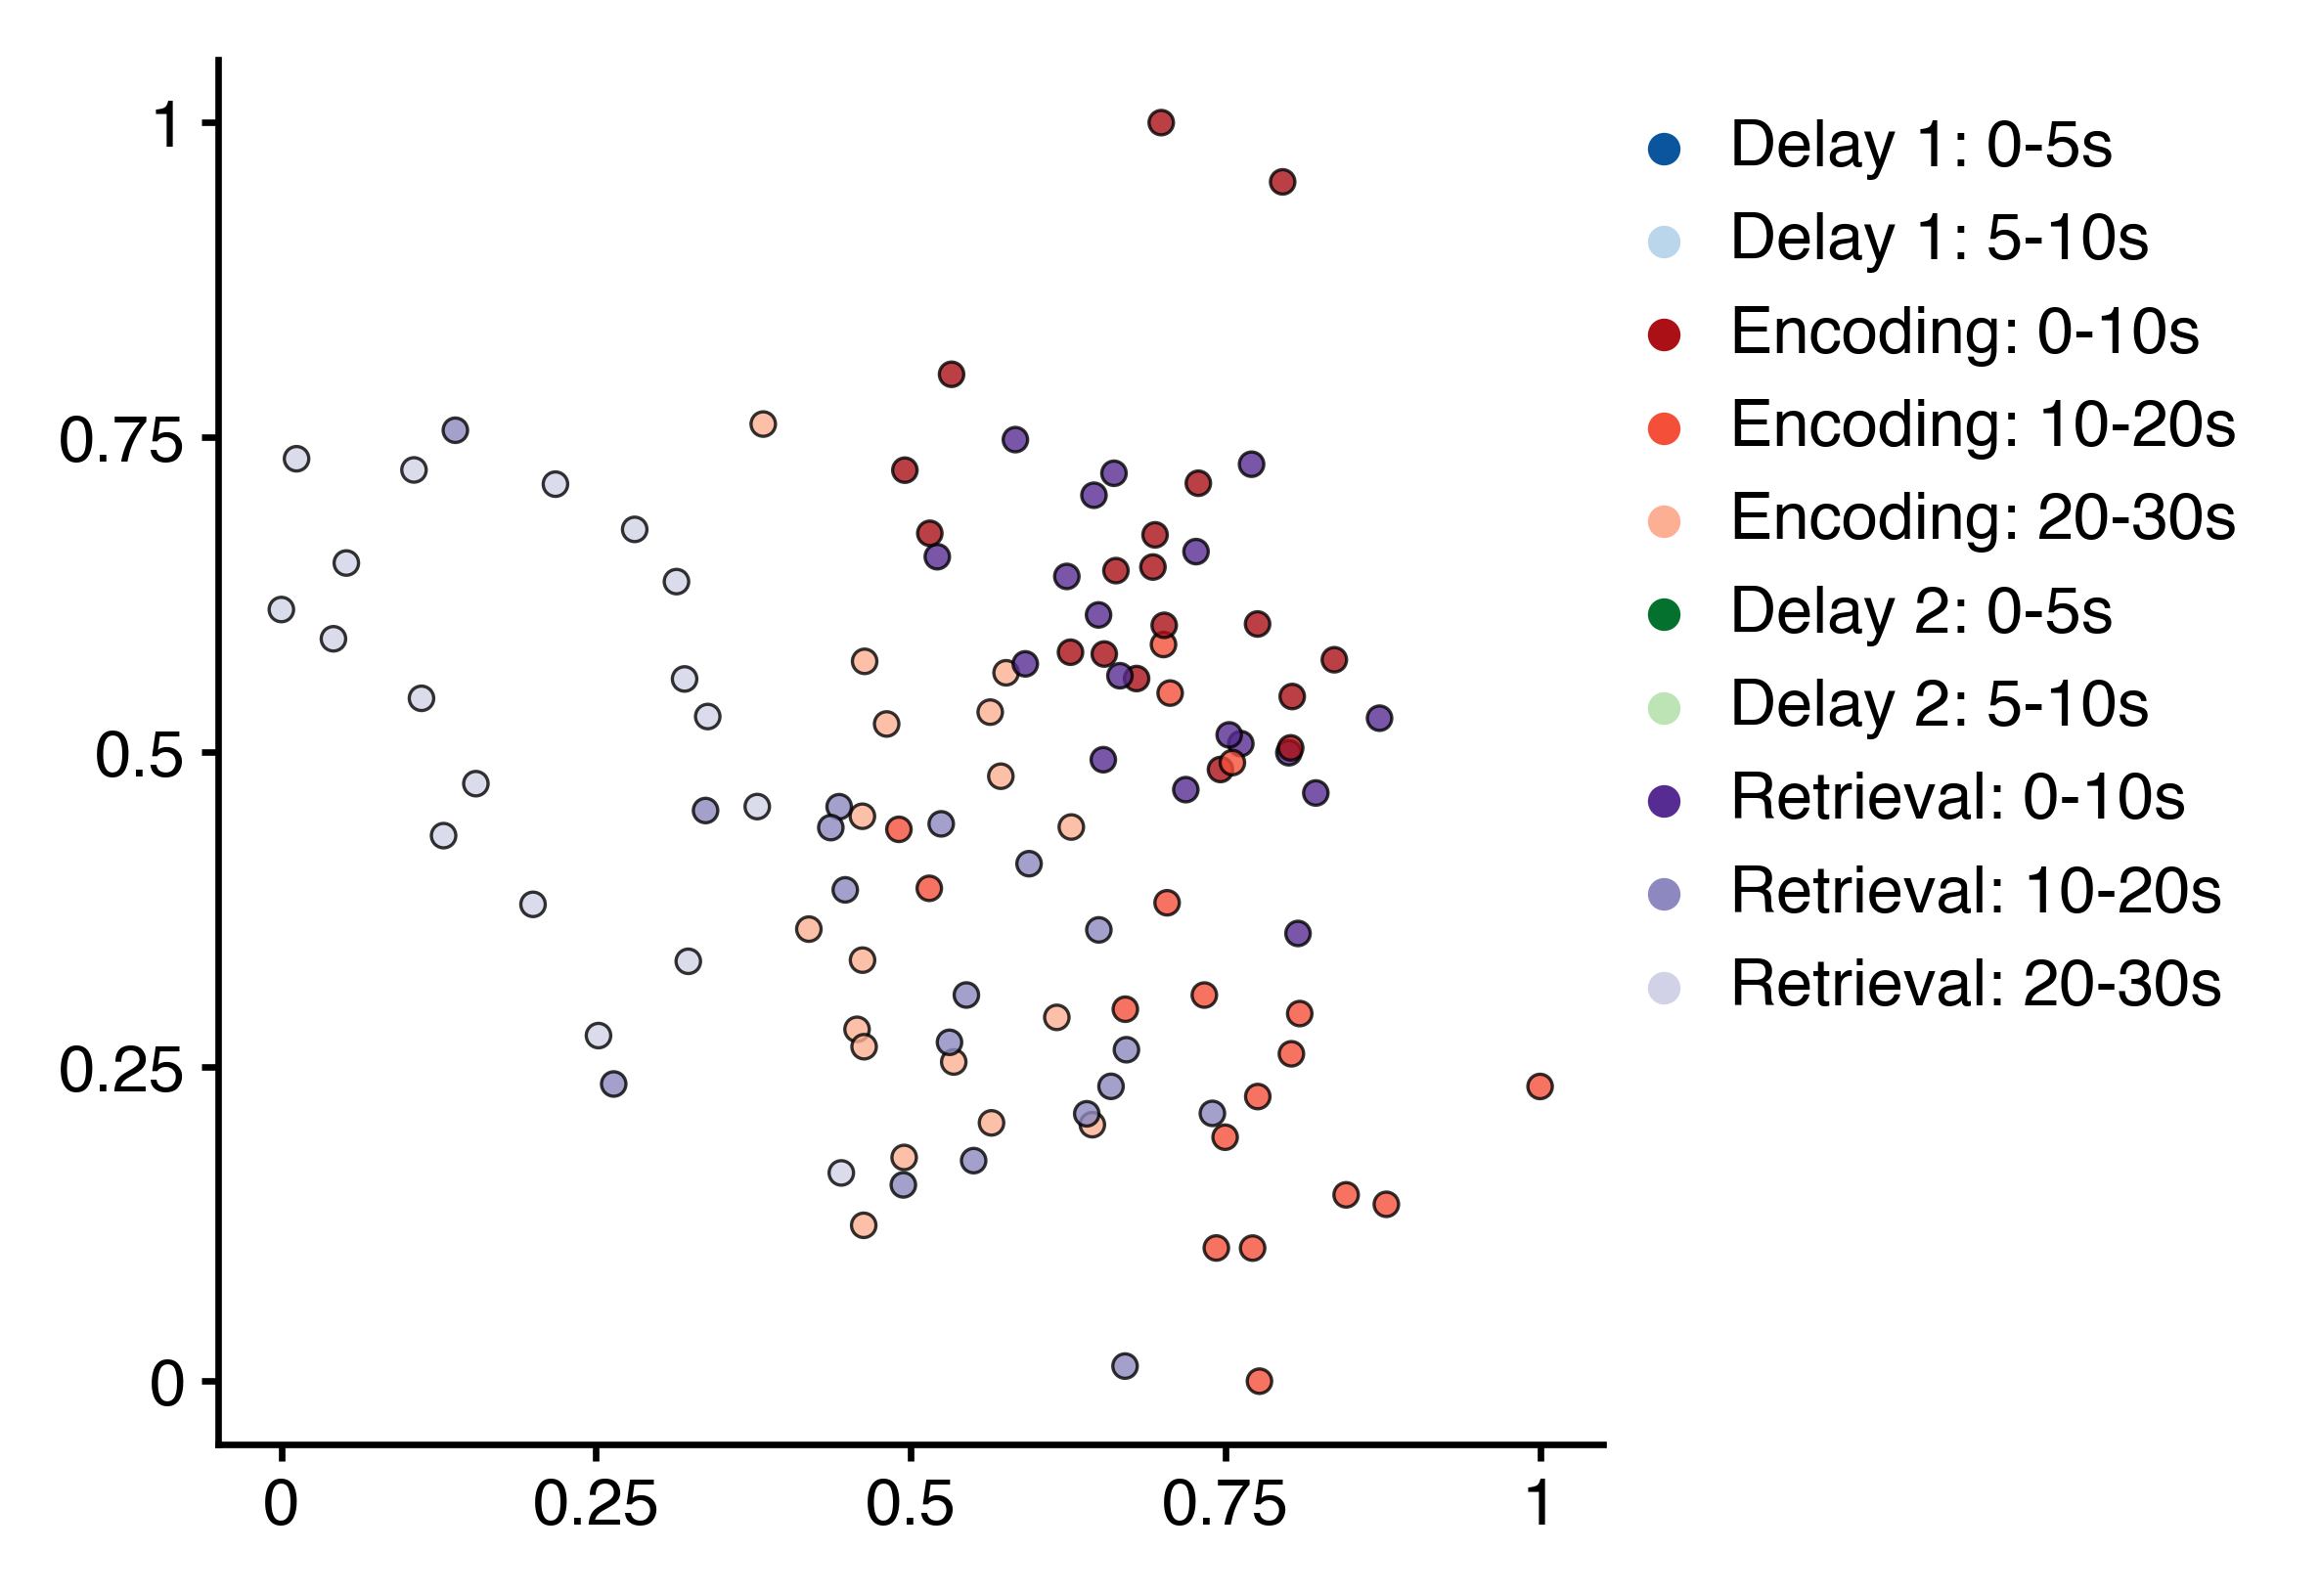

In [70]:
# Project population neural firing onto the first 2 linear discriminant components.
yvar = 'gameStateTime'

_pop_spikes = _pop_spikes.loc[np.isin(_pop_spikes['gameState'], ['Encoding', 'Retrieval'])].reset_index(drop=True)

# Select the training and test data.
odd_idx = _pop_spikes.query("(is_odd==True)").index.tolist()
even_idx = _pop_spikes.query("(is_odd!=True)").index.tolist()
X_odd = _pop_spikes.loc[odd_idx, neurons].values.copy()
y_odd = _pop_spikes.loc[odd_idx, yvar].values.copy()
X_even = _pop_spikes.loc[even_idx, neurons].values.copy()
y_even = _pop_spikes.loc[even_idx, yvar].values.copy()

# Train the classifier on odd trials.
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=2)
X_odd_lda = lda.fit_transform(X_odd, y_odd)

# Fit the classifier on even trials.
X_even_lda = lda.transform(X_even)

# Add LDA columns to the dataframe.
_pop_spikes['c1'] = np.nan
_pop_spikes['c2'] = np.nan
_pop_spikes.loc[odd_idx, 'c1'] = X_odd_lda[:, 0]
_pop_spikes.loc[odd_idx, 'c2'] = X_odd_lda[:, 1]
_pop_spikes.loc[even_idx, 'c1'] = X_even_lda[:, 0]
_pop_spikes.loc[even_idx, 'c2'] = X_even_lda[:, 1]

# Plot the results.
# plt.close()
# fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=600)
plot_embedding(_pop_spikes.loc[even_idx, :], 'c1', 'c2', hue=yvar)

fig.tight_layout()
fig.show()

# 3D LDA

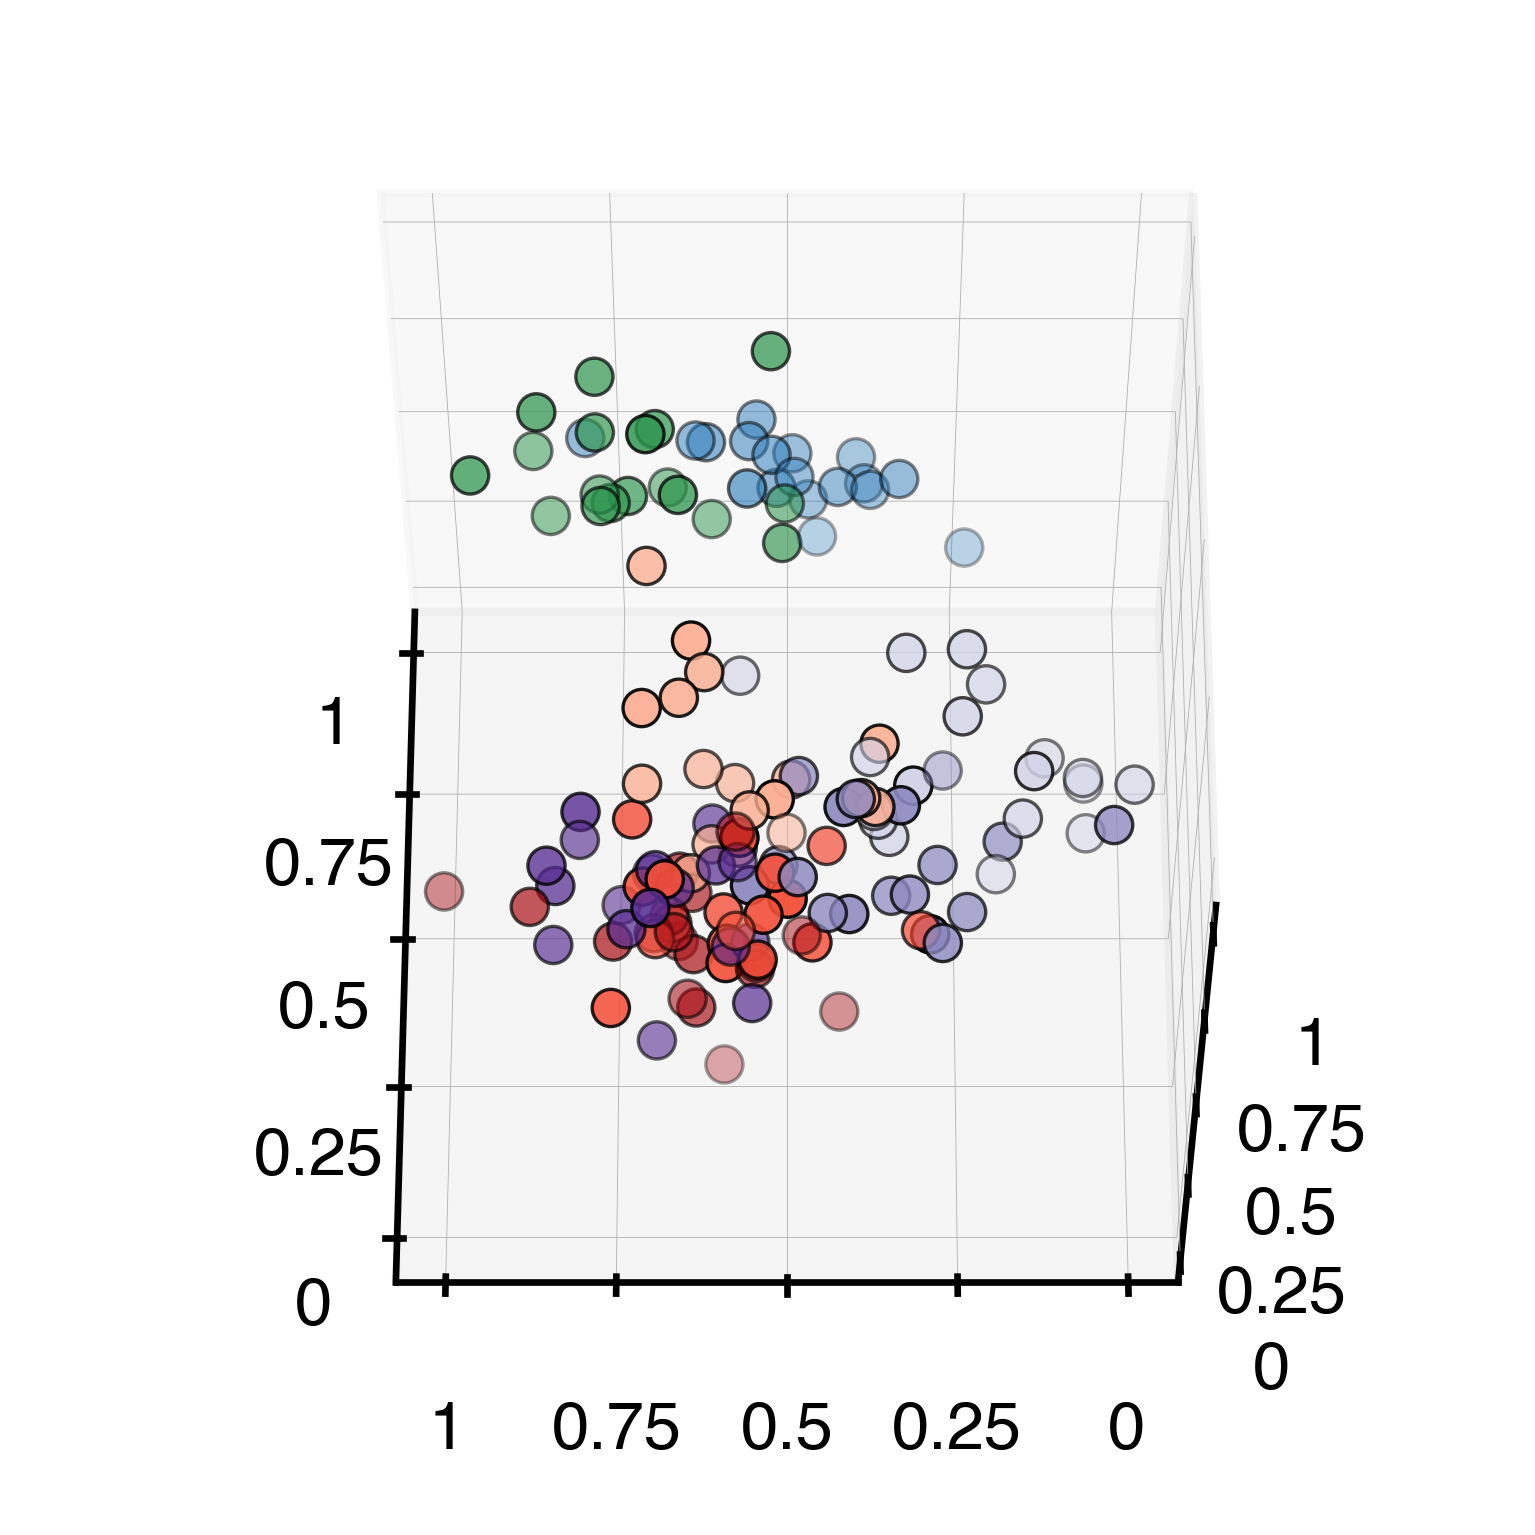

In [10]:
# Project population neural firing onto the first 3 linear discriminant components.
yvar = 'gameStateTime'

# Select the training and test data.
odd_idx = _pop_spikes.query("(is_odd==True)").index.tolist()
even_idx = _pop_spikes.query("(is_odd!=True)").index.tolist()
X_odd = _pop_spikes.loc[odd_idx, neurons].values.copy()
y_odd = _pop_spikes.loc[odd_idx, yvar].values.copy()
X_even = _pop_spikes.loc[even_idx, neurons].values.copy()
y_even = _pop_spikes.loc[even_idx, yvar].values.copy()

# Train the classifier on odd trials.
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=3)
X_odd_lda = lda.fit_transform(X_odd, y_odd)

# Fit the classifier on even trials.
X_even_lda = lda.transform(X_even)

# Add LDA columns to the dataframe.
for ii, col in enumerate(['c1', 'c2', 'c3']):
    _pop_spikes[col] = np.nan
    _pop_spikes.loc[odd_idx, col] = X_odd_lda[:, ii]
    _pop_spikes.loc[even_idx, col] = X_even_lda[:, ii]

# Plot the results.
fig, ax = plot_embedding_3d(_pop_spikes.loc[even_idx, :], 'c1', 'c2', 'c3', hue=yvar)

# rotate the axes and update
ax.view_init(60, 180)
# plt.draw()
# plt.pause(.001)

# SVC

In [823]:
# Predict time within each game state from population neural activity,
# using support vector classification with nested cross-validation.
start_time = time()

# Input params.
y_col = 'time_step'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
time_steps_per_game_state = {'Delay1': 10,
                             'Encoding': 30,
                             'Delay2': 10,
                             'Retrieval': 30}
n_perm = 1000
n_trials = 36
n_test_trials = 6
kfold_inner = 5
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search
save_results = True
overwrite = True
verbose = 0

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def setup_param_search():
    """Return an estimator."""
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

clf_results = []
for game_state in game_states:
    print('{}: {:.1f}s'.format(game_state, time() - start_time))
    
    # Select time bins across trials for the current game state.
    _pop_spikes = pop_spikes.query("(gameState=='{}')".format(game_state)).copy()

    # Aggregate time bins into a defined number of equal-size, larger time steps.
    n_time_bins = np.unique(_pop_spikes['time_bin']).size
    n_time_steps = time_steps_per_game_state[game_state]
    bins_per_step = int(n_time_bins / n_time_steps)
    _pop_spikes.insert(2, 'time_step', _pop_spikes['time_bin'].apply(lambda time_bin: int(time_bin/bins_per_step)))

    # For each unit, sum spikes within each time step.
    _pop_spikes = _pop_spikes.groupby(['gameState', 'trial', 'time_step'], observed=True)[neurons].apply(np.sum).reset_index()
    
    # Randomly split trials into test and trainval sets.
    test_trainval = []
    for iPerm in range(n_perm):
        trials = np.random.permutation(np.arange(1, n_trials+1)).tolist()
        test_trainval.append([trials[:n_test_trials], trials[n_test_trials:]])

    # Perform repeated, nested cross-validation, splitting trials into 
    # test and nested train/val sets.
    for iPerm in range(n_perm):
        # Select the test and trainval trials.
        test, trainval = test_trainval[iPerm]
        
        # ---------------------------------
        # Observed data:
        #
        # Split trials into trainval and test sets.
        X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
        y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
        X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
        y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

        # Setup grid search on the inner CV.
        clf = setup_param_search()

        # Train the model on trainval data.
        clf.fit(X_trainval, y_trainval)
        best_trainval_score = clf.best_score_
        best_trainval_C = clf.best_params_['svc__C']
        best_trainval_gamma = clf.best_params_['svc__gamma']

        # Predict time from neural activity on test data.
        y_test_pred = clf.predict(X_test).tolist()

        # Calculate accuracy.
        accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
        acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
        mean_acc = np.mean(accuracy)

        # ---------------------------------
        # Null distribution:
        #
        # Circ-shift time steps within each trial to randomize 
        # time_step ~ pop_spiking associations across trials.
        shuf_idx = np.concatenate(_pop_spikes.reset_index()
                                             .groupby('trial')['index']
                                             .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                             .tolist())
        _pop_spikes_null = _pop_spikes.copy()
        _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values
        
        # Split trials into trainval and test sets, using the same split as
        # for the observed data.
        X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
        y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
        X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
        y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

        # Setup grid search on the inner CV.
        clf_null = setup_param_search()

        # Train the model on trainval data.
        clf_null.fit(X_trainval_null, y_trainval_null)
        best_trainval_score_null = clf_null.best_score_
        best_trainval_C_null = clf_null.best_params_['svc__C']
        best_trainval_gamma_null = clf_null.best_params_['svc__gamma']
        
        # Predict time from neural activity on test data.
        y_test_pred_null = clf_null.predict(X_test_null).tolist()

        # Calculate accuracy.
        accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
        acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
        mean_acc_null = np.mean(accuracy_null)
        
        # Append results to the output dataframe.
        clf_results.append([game_state,
                            n_time_steps,
                            test,
                            best_trainval_score,
                            best_trainval_C,
                            best_trainval_gamma,
                            y_test,
                            y_test_pred,
                            mean_acc,
                            acc_by_time,
                            accuracy,
                            clf,
                            best_trainval_score_null,
                            best_trainval_C_null,
                            best_trainval_gamma_null,
                            y_test_null,
                            y_test_pred_null,
                            mean_acc_null,
                            acc_by_time_null,
                            accuracy_null,
                            clf_null])

cols = ['gameState',
        'n_time_steps',
        'test_trials',
        'best_trainval_score',
        'best_trainval_C',
        'best_trainval_gamma',
        'y_test',
        'y_test_pred',
        'mean_acc',
        'acc_by_time',
        'accuracy',
        'clf',
        'best_trainval_score_null',
        'best_trainval_C_null',
        'best_trainval_gamma_null',
        'y_test_null',
        'y_test_pred_null',
        'mean_acc_null',
        'acc_by_time_null',
        'accuracy_null',
        'clf_null']
clf_results = pd.DataFrame(clf_results, columns=cols)

if save_results:
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}units'.format(len(neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}perm'.format(n_perm)
    basename += '-' + '-'.join(['{}_{}bins'.format(game_state, time_steps_per_game_state[game_state]) for game_state in game_states])
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if overwrite or not op.exists(filename):
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f}s'.format(time() - start_time))

Delay1: 0.0s
Encoding: 493.3s
Delay2: 2965.0s
Retrieval: 3445.9s
Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_time_step-407units-random_search-Delay1_10bins-Encoding_30bins-Delay2_10bins-Retrieval_30bins.pkl
Done in 5935.0s


In [842]:
filename = op.join(proj_dir, 'analysis', 'classifiers', 
                   'SVC_predicting_time_step-407units-random_search-Delay1_5bins-Encoding_15bins-Delay2_5bins-Retrieval_15bins.pkl')
clf_results = dio.open_pickle(filename)

Delay1: 41.8 ± 6.6% (t(99)=23.3, p=5.227795928145351e-42)
Delay2: 33.5 ± 7.2% (t(99)=13.6, p=1.938790135158869e-24)


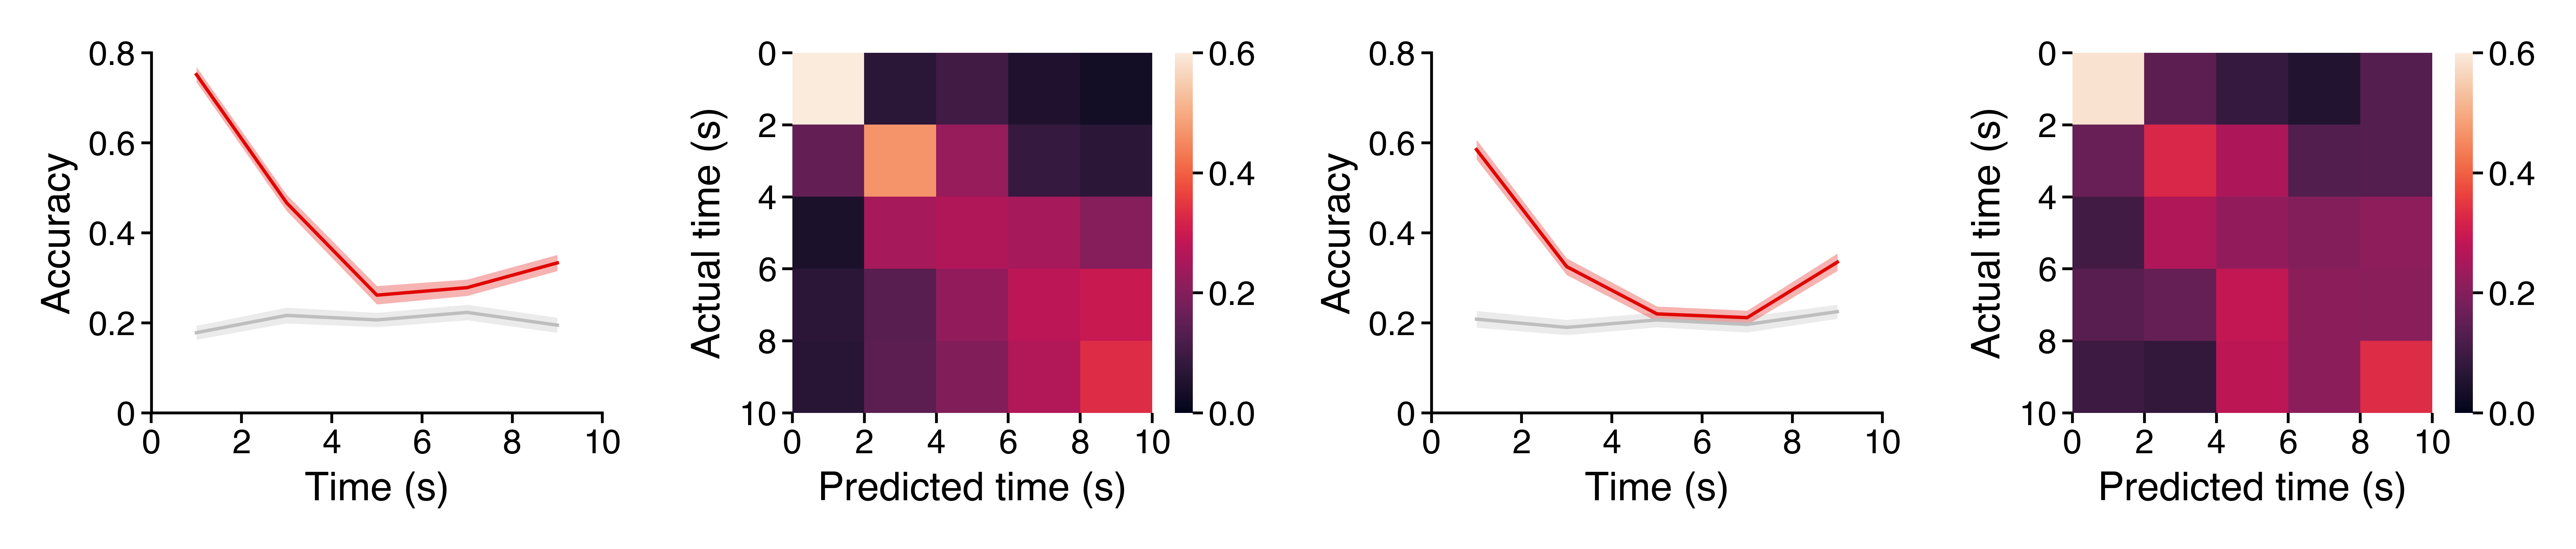

In [846]:
figsize = (colws[3], colws[1]*0.7)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 9, 'annot': 6}
xticks = np.linspace(0, 5, num=6)
# xticklabels = ['0-2', '2-4', '4-6', '6-8', '8-10']
# xticks = np.linspace(0, 10, num=6)
xticklabels = [0, 2, 4, 6, 8, 10]
ymin = 0
ymax = 0.8
yticks = [0, 0.2, 0.4, 0.6, 0.8]
vmin = 0
vmax = 0.6
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
add_cbar = True
plot_null = True

# -----------------------------------------
plt.close()
fig, ax = plt.subplots(1, 4, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)

for iState, game_state in enumerate(['Delay1', 'Delay2']):
    iax = 2 * iState
    clf_dat = clf_results.query("(gameState=='{}')".format(game_state))
    n_test = len(clf_dat.iloc[0]['test_trials'])
    n_time_steps = clf_dat.iloc[0]['n_time_steps']
    reshp = [n_test, n_time_steps]
    
    # Report mean accuracy.
    _mean = clf_dat['mean_acc'].mean()
    _std = clf_dat['mean_acc'].std()
    df = len(clf_dat) - 1
    tval, pval = stats.ttest_rel(clf_dat['mean_acc'], clf_dat['mean_acc_null'])
    print('{}: {:.1f} ± {:.1%} (t({})={:.1f}, p={})'.format(game_state, _mean * 100, _std, df, tval, pval))
    
    _means = np.mean(clf_dat['acc_by_time'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['acc_by_time'].tolist(), axis=0)
    ax[iax].fill_between(np.arange(len(_means)), _means + _sems, _means - _sems,
                         color='#e10600', linewidth=0, alpha=0.3)
    ax[iax].plot(_means, color='#e10600', linewidth=0.6)
    if plot_null:
        _means_null = np.mean(clf_dat['acc_by_time_null'].tolist(), axis=0)
        _sems_null = stats.sem(clf_dat['acc_by_time_null'].tolist(), axis=0)
        ax[iax].fill_between(np.arange(len(_means_null)), _means_null + _sems_null, _means_null - _sems_null,
                             color='#bebebe', linewidth=0, alpha=0.3, zorder=0)
        ax[iax].plot(_means_null, color='#bebebe', linewidth=0.6, zorder=1)
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
    _xticks = xticks - 0.5
    ax[iax].set_xticks(_xticks)
    ax[iax].set_xticklabels(xticklabels)
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_ylabel('Accuracy', fontsize=font['label'], labelpad=labelpad)
        
    iax += 1
    cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0)
    vmin = vmin
    vmax = vmax
    ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, ax=ax[iax])
    ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
    _xticks = xticks
    ax[iax].set_xlim((_xticks.min(), _xticks.max()))
    ax[iax].set_xticks(_xticks)
    ax[iax].set_xticklabels(xticklabels)
    ax[iax].set_yticks(ax[iax].get_xticks())
    ax[iax].set_yticklabels(ax[iax].get_xticklabels(), rotation=0)
    ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
    ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)

    if add_cbar:
        cbar = ax[iax].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    else:
        ax[iax].collections[0].colorbar.remove()
        
fig.tight_layout(pad=1.02)
fig.show()

Encoding: 30.2 ± 4.2% (t(99)=51.3, p=4.1511990305391844e-73)
Retrieval: 26.2 ± 3.7% (t(99)=43.8, p=1.2171753926815715e-66)


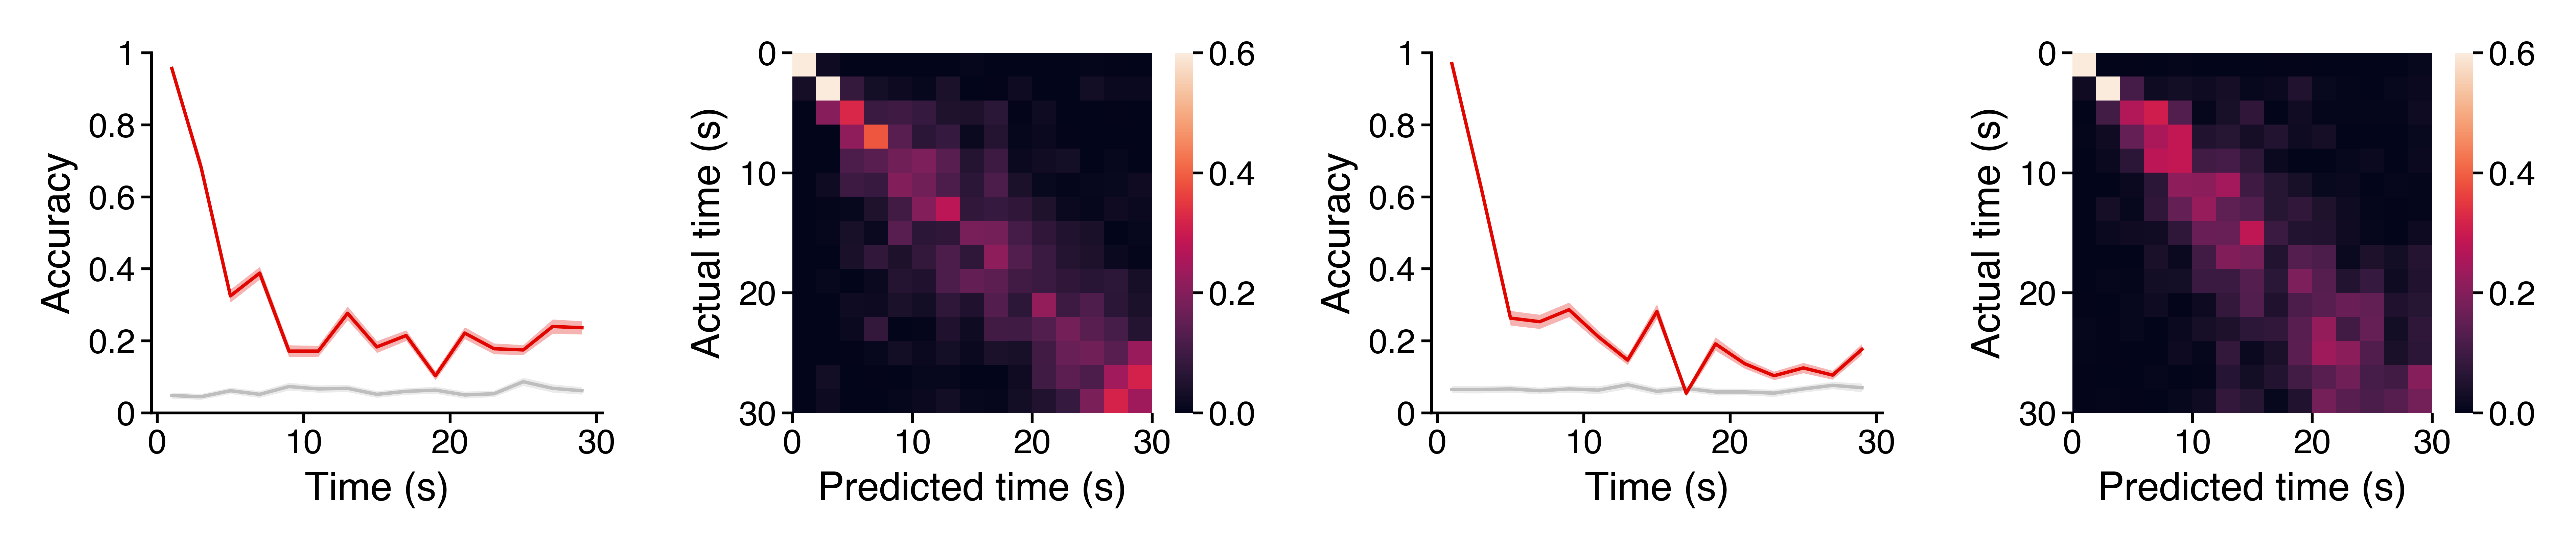

In [845]:
figsize = (colws[3], colws[1]*0.7)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 9, 'annot': 6}
xticks = np.linspace(0, 15, num=4)
# xticks = np.linspace(0, 30, num=4)
xticklabels = [0, 10, 20, 30]
ymin= 0
ymax = 1
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
vmin = 0
vmax = 0.6
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
add_cbar = True
plot_null = True

# -----------------------------------------
plt.close()
fig, ax = plt.subplots(1, 4, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)

for iState, game_state in enumerate(['Encoding', 'Retrieval']):
    iax = 2 * iState
    clf_dat = clf_results.query("(gameState=='{}')".format(game_state))
    n_test = len(clf_dat.iloc[0]['test_trials'])
    n_time_steps = clf_dat.iloc[0]['n_time_steps']
    reshp = [n_test, n_time_steps]
    
    # Report mean accuracy.
    _mean = clf_dat['mean_acc'].mean()
    _std = clf_dat['mean_acc'].std()
    df = len(clf_dat) - 1
    tval, pval = stats.ttest_rel(clf_dat['mean_acc'], clf_dat['mean_acc_null'])
    print('{}: {:.1f} ± {:.1%} (t({})={:.1f}, p={})'.format(game_state, _mean * 100, _std, df, tval, pval))
    
    _means = np.mean(clf_dat['acc_by_time'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['acc_by_time'].tolist(), axis=0)
    ax[iax].fill_between(np.arange(len(_means)), _means + _sems, _means - _sems,
                         color='#e10600', linewidth=0, alpha=0.3)
    ax[iax].plot(_means, color='#e10600', linewidth=0.6)
    if plot_null:
        _means_null = np.mean(clf_dat['acc_by_time_null'].tolist(), axis=0)
        _sems_null = stats.sem(clf_dat['acc_by_time_null'].tolist(), axis=0)
        ax[iax].fill_between(np.arange(len(_means_null)), _means_null + _sems_null, _means_null - _sems_null,
                             color='#bebebe', linewidth=0, alpha=0.3, zorder=0)
        ax[iax].plot(_means_null, color='#bebebe', linewidth=0.6, zorder=1)
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
    _xticks = xticks - 0.5
    ax[iax].set_xticks(_xticks)
    ax[iax].set_xticklabels(xticklabels)
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_ylabel('Accuracy', fontsize=font['label'], labelpad=labelpad)
        
    iax += 1
    cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0)
    vmin = vmin
    vmax = vmax
    ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, ax=ax[iax])
    ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
    _xticks = xticks
    ax[iax].set_xlim((_xticks.min(), _xticks.max()))
    ax[iax].set_xticks(_xticks)
    ax[iax].set_xticklabels(xticklabels)
    ax[iax].set_yticks(ax[iax].get_xticks())
    ax[iax].set_yticklabels(ax[iax].get_xticklabels(), rotation=0)
    ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
    ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)

    if add_cbar:
        cbar = ax[iax].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    else:
        ax[iax].collections[0].colorbar.remove()
        
fig.tight_layout(pad=1.02)
fig.show()

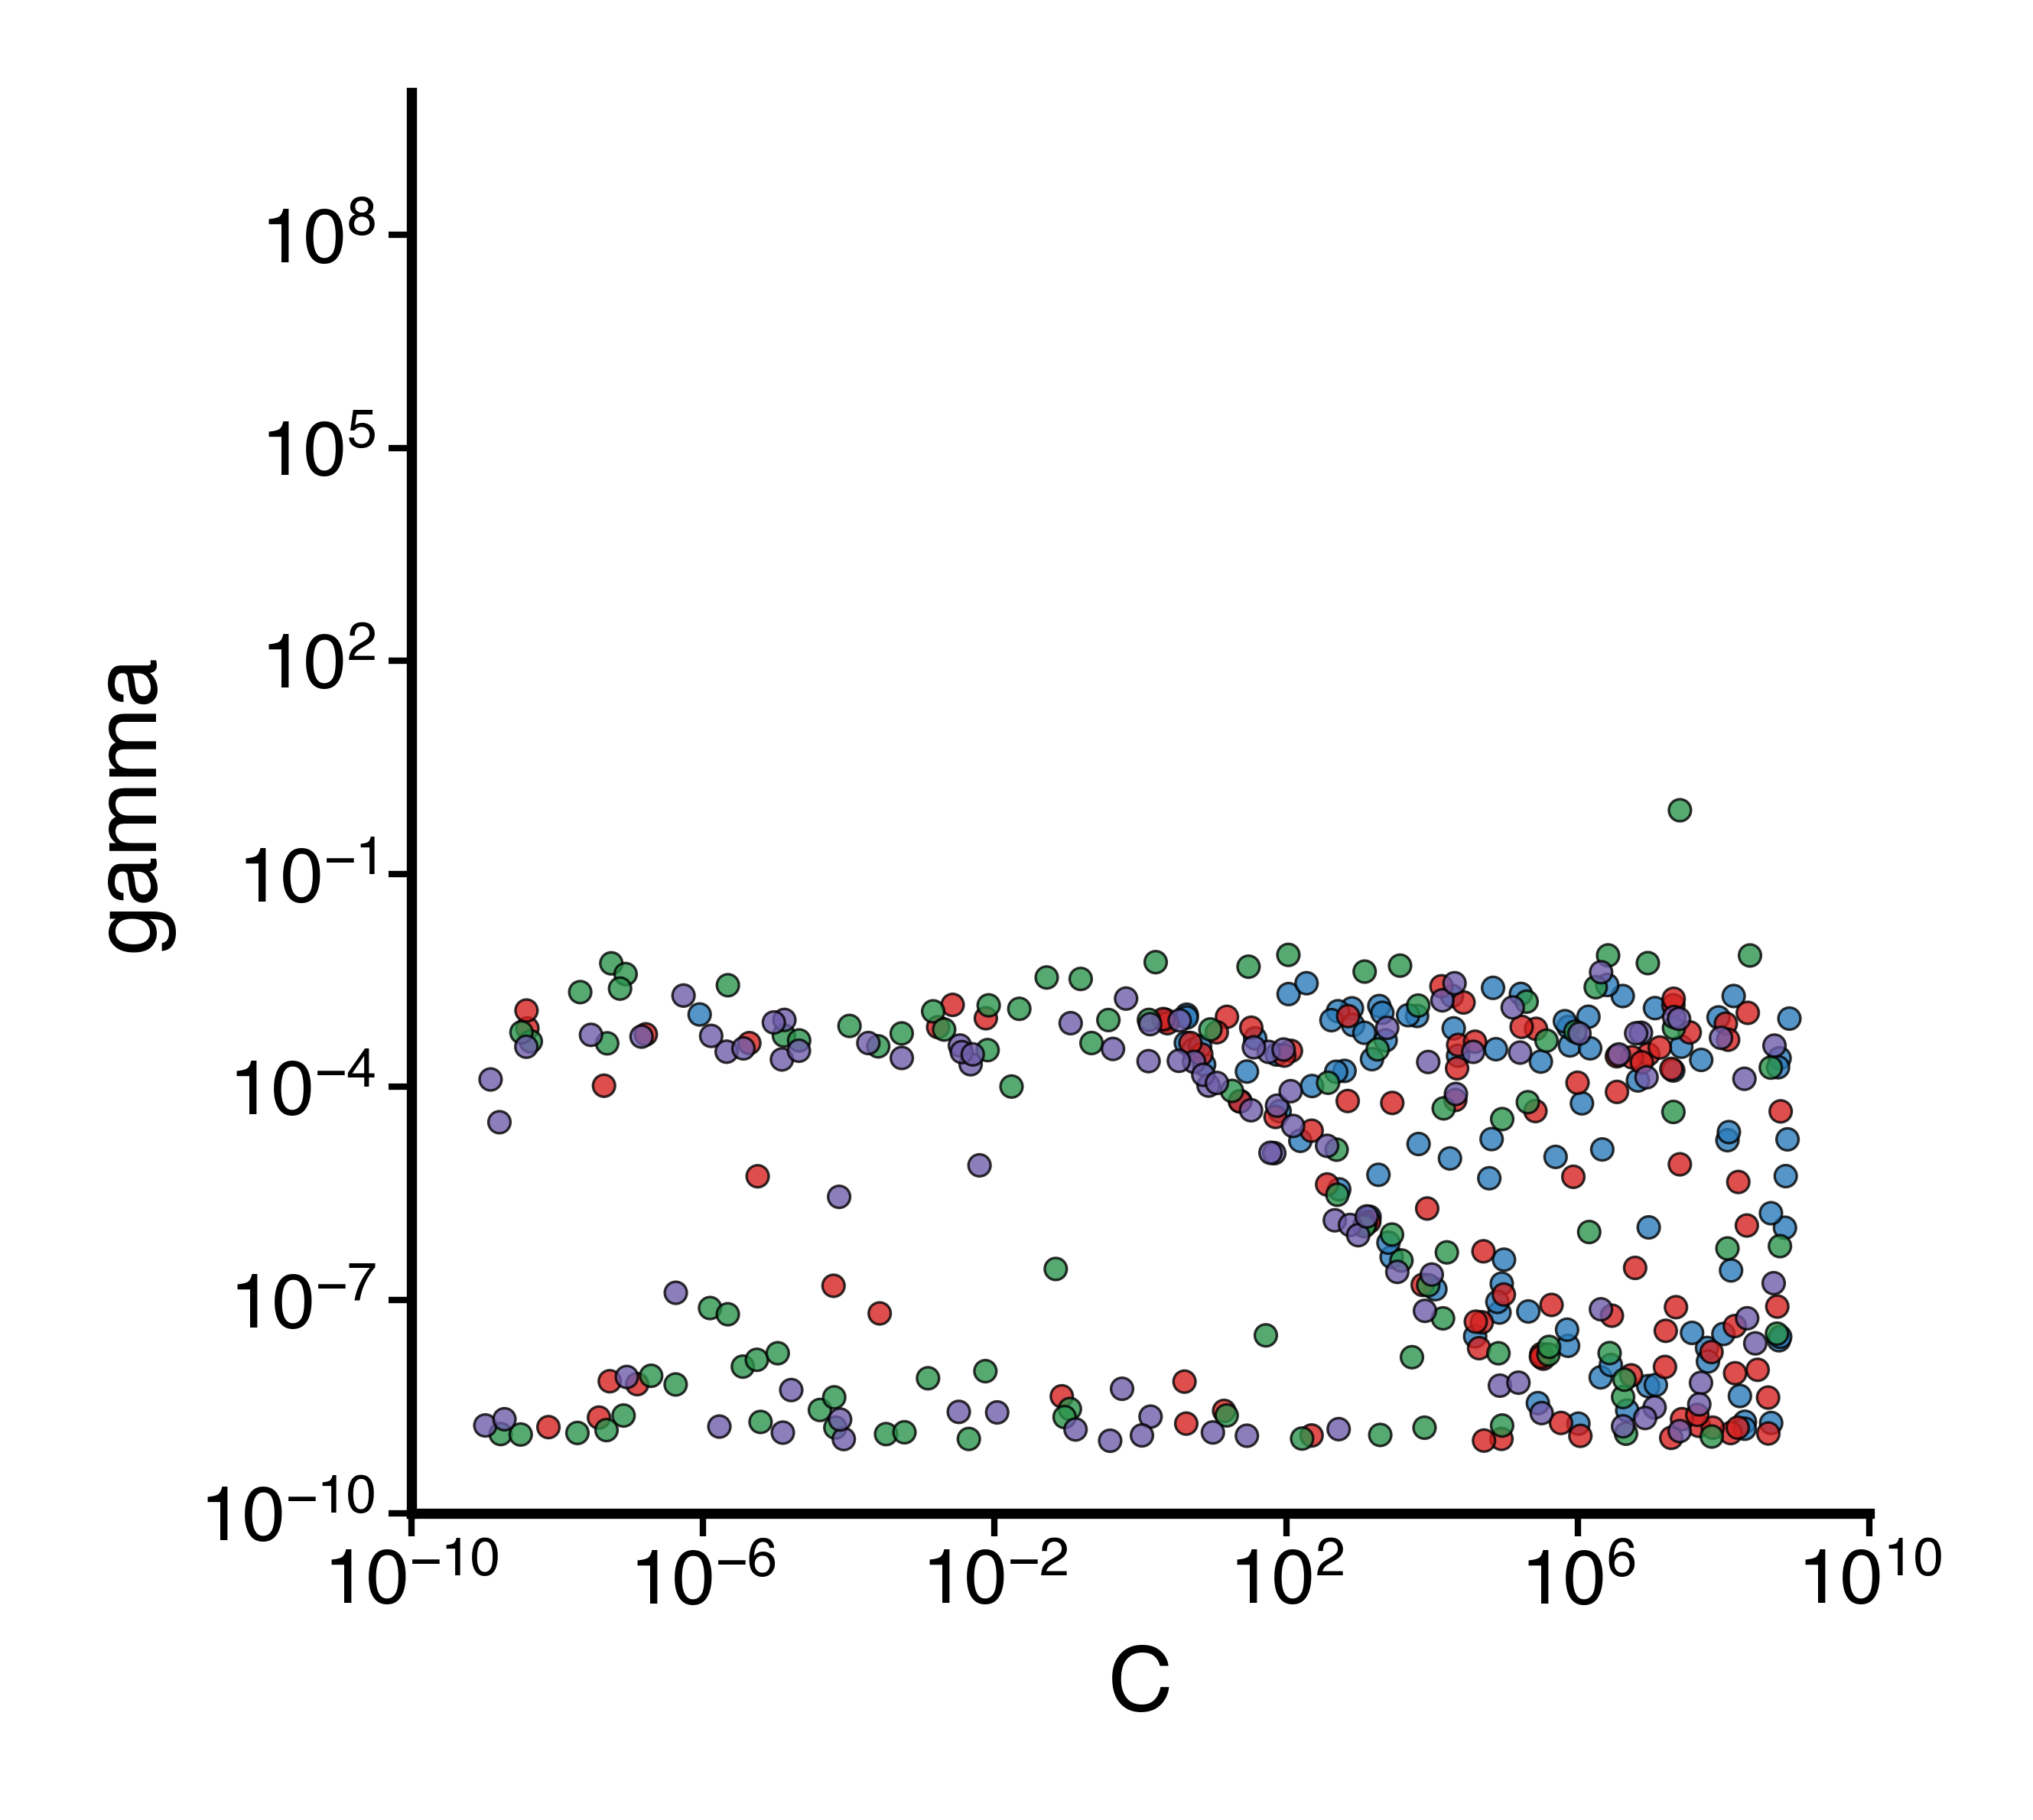

In [814]:
# Visualize best-fit parameters.
show_legend = False
font = {'tick': 6, 'label': 7, 'fig': 9, 'annot': 6}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
_cmap = [sns.color_palette('Blues')[4],
         sns.color_palette('Reds')[4],
         sns.color_palette('Greens')[4],
         sns.color_palette('Purples')[4]]

plt.close()
fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1]), dpi=1200)
ax = sns.scatterplot(x='best_trainval_C', y='best_trainval_gamma', hue='gameState', data=clf_results, ax=ax,
                     palette=_cmap, s=3, alpha=0.8, linewidth=0.2, edgecolor='k')
ax.tick_params(labelsize=font['tick'], length=spine_len, width=spine_lw, pad=1, color='k')
ax.set_xlim([1e-10, 1e10])
ax.set_xscale('log')
ax.set_xlabel('C', fontsize=font['label'], labelpad=labelpad)
ax.set_ylim(ax.get_xlim())
ax.set_yscale(ax.get_xscale())
ax.set_ylabel('gamma', fontsize=font['label'], labelpad=labelpad)
if show_legend:
    legend = ax.legend(loc=1, fontsize=font['annot'], handletextpad=0, bbox_to_anchor=[1.35, 1])
else:
    ax.get_legend().remove()

fig.show()

In [917]:
# Predict game state from population neural activity,
# using support vector classification with nested cross-validation.
start_time = time()

# Input params.
y_col = 'iGameState'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
n_perm = 100
n_trials = 36
n_test_trials = 6
kfold_inner = 5
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search
save_results = True
overwrite = True
verbose = 0

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def setup_param_search():
    """Return an estimator."""
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# Select time bins across trials for the current game state.
_pop_spikes = pop_spikes.query("(gameState=={})".format(game_states)).copy()

# Sort by trial, game state, and time bin.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameState', 'time_bin']).reset_index(drop=True)

# For each unit, sum spikes within each game state.
_pop_spikes = _pop_spikes.groupby(['trial', 'iGameState'], observed=True)[neurons].apply(np.sum).reset_index()

# Randomly split trials into test and trainval sets.
test_trainval = []
for iPerm in range(n_perm):
    trials = np.random.permutation(np.arange(1, n_trials+1)).tolist()
    test_trainval.append([trials[:n_test_trials], trials[n_test_trials:]])

# Perform repeated, nested cross-validation, splitting trials into
# test and nested train/val sets.
clf_results = []
for iPerm in range(n_perm):
    # Select the test and trainval trials.
    test, trainval = test_trainval[iPerm]

    # ---------------------------------
    # Observed data:
    #
    # Split trials into trainval and test sets.
    X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
    y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
    X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
    y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf = setup_param_search()

    # Train the model on trainval data.
    clf.fit(X_trainval, y_trainval)
    best_trainval_score = clf.best_score_
    best_trainval_C = clf.best_params_['svc__C']
    best_trainval_gamma = clf.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred = clf.predict(X_test).tolist()

    # Calculate accuracy.
    accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
    acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), len(game_states)))
    mean_acc = np.mean(accuracy)

    # ---------------------------------
    # Null distribution:
    #
    # Circ-shift time steps within each trial to randomize 
    # time_step ~ pop_spiking associations across trials.
    shuf_idx = np.concatenate(_pop_spikes.reset_index()
                                         .groupby('trial')['index']
                                         .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                         .tolist())
    _pop_spikes_null = _pop_spikes.copy()
    _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

    # Split trials into trainval and test sets, using the same split as
    # for the observed data.
    X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
    y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
    X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
    y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf_null = setup_param_search()

    # Train the model on trainval data.
    clf_null.fit(X_trainval_null, y_trainval_null)
    best_trainval_score_null = clf_null.best_score_
    best_trainval_C_null = clf_null.best_params_['svc__C']
    best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred_null = clf_null.predict(X_test_null).tolist()

    # Calculate accuracy.
    accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
    acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), len(game_states)))
    mean_acc_null = np.mean(accuracy_null)

    # Append results to the output dataframe.
    clf_results.append([y_col,
                        len(game_states),
                        test,
                        best_trainval_score,
                        best_trainval_C,
                        best_trainval_gamma,
                        y_test,
                        y_test_pred,
                        mean_acc,
                        acc_by_time,
                        accuracy,
                        best_trainval_score_null,
                        best_trainval_C_null,
                        best_trainval_gamma_null,
                        y_test_null,
                        y_test_pred_null,
                        mean_acc_null,
                        acc_by_time_null,
                        accuracy_null])

cols = ['iGameState',
        'n_time_steps',
        'test_trials',
        'best_trainval_score',
        'best_trainval_C',
        'best_trainval_gamma',
        'y_test',
        'y_test_pred',
        'mean_acc',
        'acc_by_time',
        'accuracy',
        'best_trainval_score_null',
        'best_trainval_C_null',
        'best_trainval_gamma_null',
        'y_test_null',
        'y_test_pred_null',
        'mean_acc_null',
        'acc_by_time_null',
        'accuracy_null']
clf_results = pd.DataFrame(clf_results, columns=cols)

if save_results:
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}units'.format(len(neurons))
    basename += '-{}_search'.format(search_method)
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if overwrite or not op.exists(filename):
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f}s'.format(time() - start_time))

Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameState-407units-random_search.pkl
Done in 344.3s


In [1004]:
filename = op.join(proj_dir, 'analysis', 'classifiers', 
                   'SVC_predicting_iGameState-407units-random_search.pkl')
clf_results = dio.open_pickle(filename)

iGameStateTime: 85.7 ± 6.6% (t(99)=55.2, p=3.515658093782878e-76)


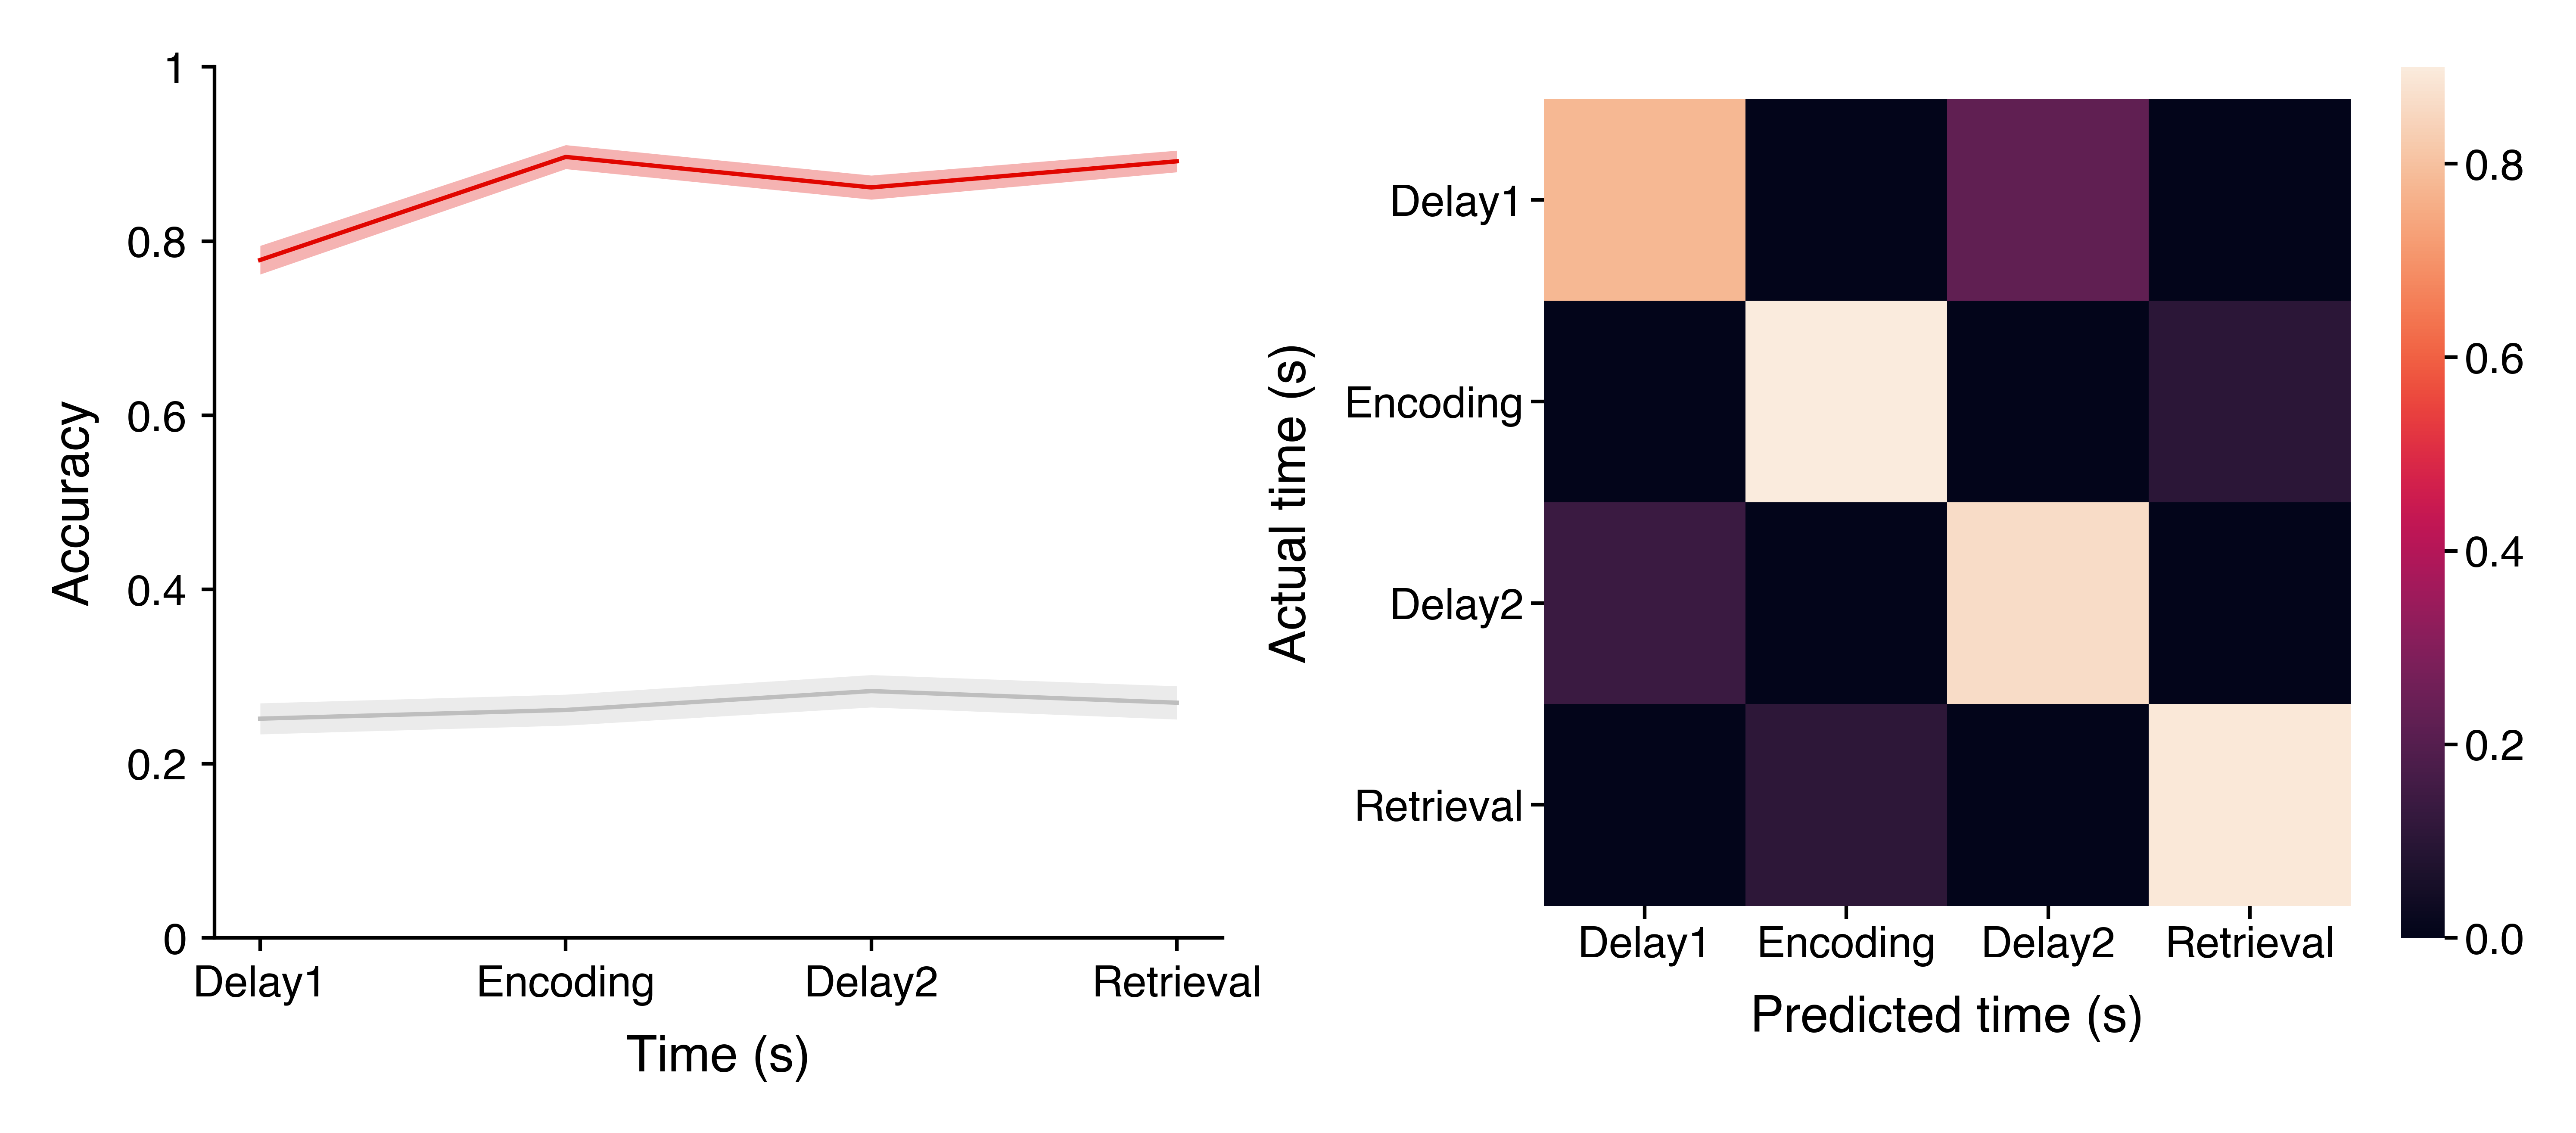

In [1005]:
figsize = (colws[3]*0.75, colws[2]*0.85*0.75)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 9, 'annot': 6}
xticks = np.arange(4)
xticklabels = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
ymin= 0
ymax = 1
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
vmin = 0
vmax = 0.9
spine_lw = 0.5
spine_len = 1.8
labelpad = 4
add_cbar = True
plot_null = True

# -----------------------------------------
plt.close()
fig, ax = plt.subplots(1, 2, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)

iax = 0
clf_dat = clf_results
n_test = len(clf_dat.iloc[0]['test_trials'])
n_time_steps = clf_dat.iloc[0]['n_time_steps']
reshp = [n_test, n_time_steps]

# Report mean accuracy.
_mean = clf_dat['mean_acc'].mean()
_std = clf_dat['mean_acc'].std()
df = len(clf_dat) - 1
tval, pval = stats.ttest_rel(clf_dat['mean_acc'], clf_dat['mean_acc_null'])
print('{}: {:.1f} ± {:.1%} (t({})={:.1f}, p={})'.format(y_col, _mean * 100, _std, df, tval, pval))

_means = np.mean(clf_dat['acc_by_time'].tolist(), axis=0)
_sems = stats.sem(clf_dat['acc_by_time'].tolist(), axis=0)
ax[iax].fill_between(np.arange(len(_means)), _means + _sems, _means - _sems,
                     color='#e10600', linewidth=0, alpha=0.3)
ax[iax].plot(_means, color='#e10600', linewidth=0.6)
if plot_null:
    _means_null = np.mean(clf_dat['acc_by_time_null'].tolist(), axis=0)
    _sems_null = stats.sem(clf_dat['acc_by_time_null'].tolist(), axis=0)
    ax[iax].fill_between(np.arange(len(_means_null)), _means_null + _sems_null, _means_null - _sems_null,
                         color='#bebebe', linewidth=0, alpha=0.3, zorder=0)
    ax[iax].plot(_means_null, color='#bebebe', linewidth=0.6, zorder=1)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=2, length=spine_len, width=spine_lw)
_xticks = xticks
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin, ymax])
ax[iax].set_yticks(yticks)
ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
ax[iax].set_ylabel('Accuracy', fontsize=font['label'], labelpad=labelpad)

iax += 1
cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0)
vmin = vmin
vmax = vmax
ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, ax=ax[iax])
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks + 0.5
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_yticks(ax[iax].get_xticks())
ax[iax].set_yticklabels(ax[iax].get_xticklabels(), rotation=0)
ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)

if add_cbar:
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
    cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
else:
    ax[iax].collections[0].colorbar.remove()
        
fig.tight_layout(pad=0)
fig.show()

In [995]:
# Predict time within each game state, across game states, from population neural activity,
# using support vector classification with nested cross-validation.
start_time = time()

# Input params.
y_col = 'iGameStateTime'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
time_steps_per_game_state = {'Delay1': 5,
                             'Encoding': 15,
                             'Delay2': 5,
                             'Retrieval': 15}
n_perm = 100
n_trials = 36
n_test_trials = 6
kfold_inner = 5
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search
save_results = True
overwrite = False
verbose = 0

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def get_bins_per_step(game_state):
    return int(n_time_bins[game_state] / time_steps_per_game_state[game_state])

def setup_param_search():
    """Return an estimator."""
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# Select time bins across trials for the current game state.
_pop_spikes = pop_spikes.query("(gameState=={})".format(game_states)).copy()

# Add a column for game state order.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))

# Aggregate time bins into a defined number of equal-size, larger time steps.
n_time_bins = _pop_spikes.groupby('gameState')['time_bin'].apply(lambda x: len(np.unique(x))).to_dict()
_pop_spikes.insert(3, 'time_step', _pop_spikes.apply(lambda x: int(x['time_bin']/get_bins_per_step(x['gameState'])), axis=1))

# Add a column that combines game state and time step.
_pop_spikes.insert(4, 'gameStateTime', _pop_spikes.apply(lambda x: '{}_{:0>2}'.format(x['iGameState'], x['time_step']), axis=1).astype(str))
i_game_state_times = {gst: igst for (igst, gst) in enumerate(np.unique(_pop_spikes['gameStateTime']))}
_pop_spikes.insert(5, 'iGameStateTime', _pop_spikes['gameStateTime'].apply(lambda x: i_game_state_times[x]).astype(int))
n_time_steps = _pop_spikes['iGameStateTime'].unique().size

# Sort by trial and game state time.
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameStateTime']).reset_index(drop=True)

# For each unit, sum spikes within each game state time.
_pop_spikes = _pop_spikes.groupby(['trial', 'iGameStateTime'], observed=True)[neurons].apply(np.sum).reset_index()

# Randomly split trials into test and trainval sets.
test_trainval = []
for iPerm in range(n_perm):
    trials = np.random.permutation(np.arange(1, n_trials+1)).tolist()
    test_trainval.append([trials[:n_test_trials], trials[n_test_trials:]])

# Perform repeated, nested cross-validation, splitting trials into 
# test and nested train/val sets.
clf_results = []
for iPerm in range(n_perm):
    # Select the test and trainval trials.
    test, trainval = test_trainval[iPerm]

    # ---------------------------------
    # Observed data:
    #
    # Split trials into trainval and test sets.
    X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
    y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
    X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
    y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf = setup_param_search()

    # Train the model on trainval data.
    clf.fit(X_trainval, y_trainval)
    best_trainval_score = clf.best_score_
    best_trainval_C = clf.best_params_['svc__C']
    best_trainval_gamma = clf.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred = clf.predict(X_test).tolist()

    # Calculate accuracy.
    accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
    acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
    mean_acc = np.mean(accuracy)

    # ---------------------------------
    # Null distribution:
    #
    # Circ-shift time steps within each trial to randomize 
    # time_step ~ pop_spiking associations across trials.
    shuf_idx = np.concatenate(_pop_spikes.reset_index()
                                         .groupby('trial')['index']
                                         .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                         .tolist())
    _pop_spikes_null = _pop_spikes.copy()
    _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

    # Split trials into trainval and test sets, using the same split as
    # for the observed data.
    X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
    y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
    X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
    y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf_null = setup_param_search()

    # Train the model on trainval data.
    clf_null.fit(X_trainval_null, y_trainval_null)
    best_trainval_score_null = clf_null.best_score_
    best_trainval_C_null = clf_null.best_params_['svc__C']
    best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred_null = clf_null.predict(X_test_null).tolist()

    # Calculate accuracy.
    accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
    acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
    mean_acc_null = np.mean(accuracy_null)

    # Append results to the output dataframe.
    clf_results.append([y_col,
                        n_time_steps,
                        test,
                        best_trainval_score,
                        best_trainval_C,
                        best_trainval_gamma,
                        y_test,
                        y_test_pred,
                        mean_acc,
                        acc_by_time,
                        accuracy,
                        best_trainval_score_null,
                        best_trainval_C_null,
                        best_trainval_gamma_null,
                        y_test_null,
                        y_test_pred_null,
                        mean_acc_null,
                        acc_by_time_null,
                        accuracy_null])

cols = ['gameState',
        'n_time_steps',
        'test_trials',
        'best_trainval_score',
        'best_trainval_C',
        'best_trainval_gamma',
        'y_test',
        'y_test_pred',
        'mean_acc',
        'acc_by_time',
        'accuracy',
        'best_trainval_score_null',
        'best_trainval_C_null',
        'best_trainval_gamma_null',
        'y_test_null',
        'y_test_pred_null',
        'mean_acc_null',
        'acc_by_time_null',
        'accuracy_null']
clf_results = pd.DataFrame(clf_results, columns=cols)

if save_results:
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}units'.format(len(neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}bins'.format(n_time_steps)
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if overwrite or not op.exists(filename):
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f}s'.format(time() - start_time))

Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameStateTime-407units-random_search-40bins.pkl
Done in 4294.9s


In [1006]:
filename = op.join(proj_dir, 'analysis', 'classifiers', 
                   'SVC_predicting_iGameStateTime-407units-random_search-40bins.pkl')
clf_results = dio.open_pickle(filename)

iGameStateTime: 24.6 ± 2.5% (t(99)=84.5, p=4.419407702378277e-94)


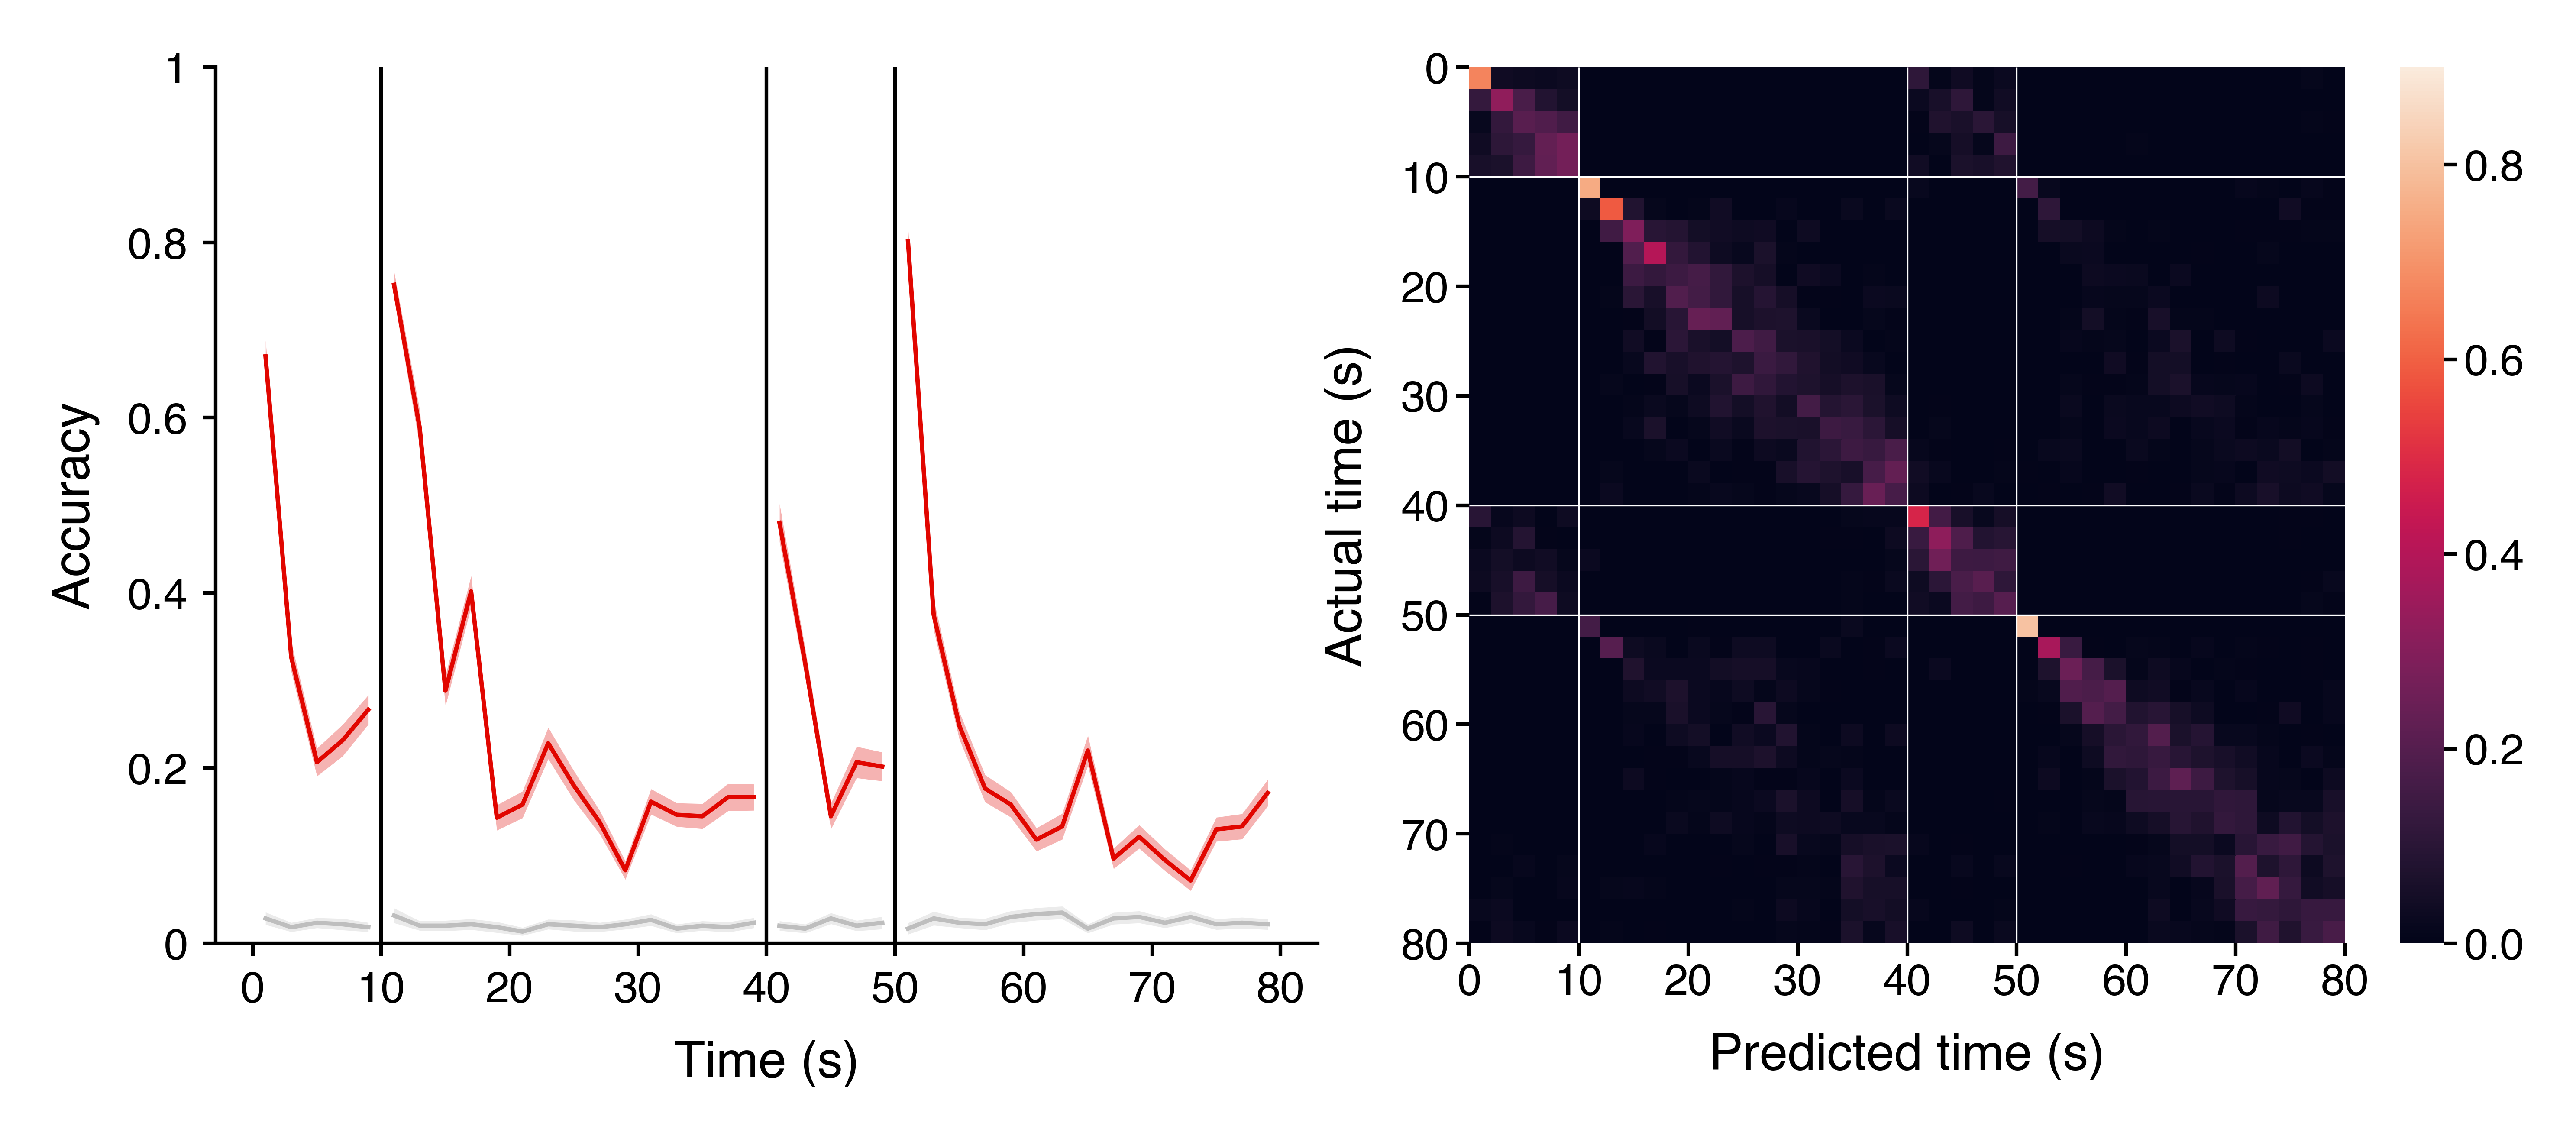

In [1003]:
figsize = (colws[3]*0.75, colws[2]*0.85*0.75)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 9, 'annot': 6}
vlines = [0, 5, 20, 25, 40]
xticks = np.arange(0, n_time_steps+1, 5)
xticklabels = xticks * 2
ymin= 0
ymax = 1
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
vmin = 0
vmax = 0.9
spine_lw = 0.5
spine_len = 1.8
labelpad = 4
add_cbar = True
plot_null = True

# -----------------------------------------
plt.close()
fig, ax = plt.subplots(1, 2, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)

iax = 0
clf_dat = clf_results
n_test = len(clf_dat.iloc[0]['test_trials'])
n_time_steps = clf_dat.iloc[0]['n_time_steps']
reshp = [n_test, n_time_steps]

# Report mean accuracy.
_mean = clf_dat['mean_acc'].mean()
_std = clf_dat['mean_acc'].std()
df = len(clf_dat) - 1
tval, pval = stats.ttest_rel(clf_dat['mean_acc'], clf_dat['mean_acc_null'])
print('{}: {:.1f} ± {:.1%} (t({})={:.1f}, p={})'.format(y_col, _mean * 100, _std, df, tval, pval))

ax[iax].vlines(np.array(vlines)[1:-1] - 0.5, ymin, ymax, colors='k', linewidths=spine_lw)
_means = np.split(np.mean(clf_dat['acc_by_time'].tolist(), axis=0), vlines[1:-1])
_sems = np.split(stats.sem(clf_dat['acc_by_time'].tolist(), axis=0), vlines[1:-1])
for ii in range(len(_means)):
    xvals = np.arange(vlines[ii], vlines[ii+1])
    ax[iax].fill_between(xvals, _means[ii] + _sems[ii], _means[ii] - _sems[ii],
                         color='#e10600', linewidth=0, alpha=0.3)
    ax[iax].plot(xvals, _means[ii], color='#e10600', linewidth=0.6)
if plot_null:
    _means_null = np.split(np.mean(clf_dat['acc_by_time_null'].tolist(), axis=0), vlines[1:-1])
    _sems_null = np.split(stats.sem(clf_dat['acc_by_time_null'].tolist(), axis=0), vlines[1:-1])
    for ii in range(len(_means_null)):
        xvals = np.arange(vlines[ii], vlines[ii+1])
        ax[iax].fill_between(xvals, _means_null[ii] + _sems_null[ii], _means_null[ii] - _sems_null[ii],
                             color='#bebebe', linewidth=0, alpha=0.3, zorder=0)
        ax[iax].plot(xvals, _means_null[ii], color='#bebebe', linewidth=0.6, zorder=1)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=2, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin, ymax])
ax[iax].set_yticks(yticks)
ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
ax[iax].set_ylabel('Accuracy', fontsize=font['label'], labelpad=labelpad)

iax += 1
cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0)
vmin = vmin
vmax = vmax

ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, ax=ax[iax])
ax[iax].hlines(np.array(vlines)[1:-1], 0, n_time_steps, colors='w', linewidths=0.2)
ax[iax].vlines(np.array(vlines)[1:-1], 0, n_time_steps, colors='w', linewidths=0.2)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_yticks(ax[iax].get_xticks())
ax[iax].set_yticklabels(ax[iax].get_xticklabels(), rotation=0)
ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)

if add_cbar:
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
    cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
else:
    ax[iax].collections[0].colorbar.remove()
        
fig.tight_layout(pad=0)
fig.show()

# Run in serial

In [ ]:
# # Predict time within each game state from population neural activity,
# # using support vector classification with nested cross-validation.
# start_time = time()

# # Input params.
# y_col = 'time_step'
# game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
# time_steps_per_game_state = {'Delay1': 10,
#                              'Encoding': 15,
#                              'Delay2': 10,
#                              'Retrieval': 15}
# n_perm = 1000
# n_trials = 36
# n_test_trials = 6
# kfold_inner = 5
# search_method = 'random' # 'grid' or 'random'
# n_vals_per_hyperparam = 7 # for grid search
# n_iter = 100 # for random search
# n_jobs = 32 # for running parameter search
# save_results = True
# overwrite = True
# verbose = 0

# # Build a processing pipeline.
# # 1. Impute missing data by replacing NaNs with their column-wise median.
# # 2. Z-score the values in each column.
# # 3. Train a support vector classifier with RBF kernel.
# pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
#                        ('scale', StandardScaler()),
#                        ('svc', SVC(kernel='rbf'))])

# # Define a function that sets up parameter search 
# # for the inner cross-validation.
# def setup_param_search():
#     """Return an estimator."""
#     inner_cv = KFold(kfold_inner)
    
#     if search_method == 'grid':    
#         param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
#                       'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
#         clf = GridSearchCV(estimator=pipe,
#                            param_grid=param_grid,
#                            refit=True,
#                            cv=inner_cv,
#                            n_jobs=n_jobs,
#                            verbose=verbose)
#     elif search_method == 'random':
#         param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
#                       'svc__gamma' : loguniform(1e-9, 1e9)}
#         clf = RandomizedSearchCV(estimator=pipe,
#                                  param_distributions=param_dist,
#                                  refit=True,
#                                  cv=inner_cv,
#                                  n_jobs=n_jobs,
#                                  n_iter=n_iter)
#     return clf

# def get_mean_accuracy(acc_vec, reshp):
#     """Return mean accuracy across time_bins.
    
#     Parameters
#     ----------
#     acc_vec : list
#         Accuracy vector comparing y_test to y_test_pred 
#         at each time bin, across test trials.
#     reshp : list
#         (n_test_trials, n_time_bins)
#     """
#     return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# clf_results = []
# for game_state in game_states:
#     print('{}: {:.1f}s'.format(game_state, time() - start_time))
    
#     # Select time bins across trials for the current game state.
#     _pop_spikes = pop_spikes.query("(gameState=='{}')".format(game_state)).copy()

#     # Aggregate time bins into a defined number of equal-size, larger time steps.
#     n_time_bins = np.unique(_pop_spikes['time_bin']).size
#     n_time_steps = time_steps_per_game_state[game_state]
#     bins_per_step = int(n_time_bins / n_time_steps)
#     _pop_spikes.insert(2, 'time_step', _pop_spikes['time_bin'].apply(lambda time_bin: int(time_bin/bins_per_step)))

#     # For each unit, sum spikes within each time step.
#     _pop_spikes = _pop_spikes.groupby(['gameState', 'trial', 'time_step'], observed=True)[neurons].apply(np.sum).reset_index()
    
#     # Randomly split trials into test and trainval sets.
#     test_trainval = []
#     for iPerm in range(n_perm):
#         trials = np.random.permutation(np.arange(1, n_trials+1)).tolist()
#         test_trainval.append([trials[:n_test_trials], trials[n_test_trials:]])

#     # Perform repeated, nested cross-validation, splitting trials into 
#     # test and nested train/val sets.
#     for iPerm in range(n_perm):
#         # Select the test and trainval trials.
#         test, trainval = test_trainval[iPerm]
        
#         # ---------------------------------
#         # Observed data:
#         #
#         # Split trials into trainval and test sets.
#         X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
#         y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
#         X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
#         y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

#         # Setup grid search on the inner CV.
#         clf = setup_param_search()

#         # Train the model on trainval data.
#         clf.fit(X_trainval, y_trainval)
#         best_trainval_score = clf.best_score_
#         best_trainval_C = clf.best_params_['svc__C']
#         best_trainval_gamma = clf.best_params_['svc__gamma']

#         # Predict time from neural activity on test data.
#         y_test_pred = clf.predict(X_test).tolist()

#         # Calculate accuracy.
#         accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
#         acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
#         mean_acc = np.mean(accuracy)

#         # ---------------------------------
#         # Null distribution:
#         #
#         # Circ-shift time steps within each trial to randomize 
#         # time_step ~ pop_spiking associations across trials.
#         shuf_idx = np.concatenate(_pop_spikes.reset_index()
#                                              .groupby('trial')['index']
#                                              .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
#                                              .tolist())
#         _pop_spikes_null = _pop_spikes.copy()
#         _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values
        
#         # Split trials into trainval and test sets, using the same split as
#         # for the observed data.
#         X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
#         y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
#         X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
#         y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

#         # Setup grid search on the inner CV.
#         clf_null = setup_param_search()

#         # Train the model on trainval data.
#         clf_null.fit(X_trainval_null, y_trainval_null)
#         best_trainval_score_null = clf_null.best_score_
#         best_trainval_C_null = clf_null.best_params_['svc__C']
#         best_trainval_gamma_null = clf_null.best_params_['svc__gamma']
        
#         # Predict time from neural activity on test data.
#         y_test_pred_null = clf_null.predict(X_test_null).tolist()

#         # Calculate accuracy.
#         accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
#         acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
#         mean_acc_null = np.mean(accuracy_null)
        
#         # Append results to the output dataframe.
#         clf_results.append([game_state,
#                             n_time_steps,
#                             test,
#                             best_trainval_score,
#                             best_trainval_C,
#                             best_trainval_gamma,
#                             y_test,
#                             y_test_pred,
#                             mean_acc,
#                             acc_by_time,
#                             accuracy,
#                             clf,
#                             best_trainval_score_null,
#                             best_trainval_C_null,
#                             best_trainval_gamma_null,
#                             y_test_null,
#                             y_test_pred_null,
#                             mean_acc_null,
#                             acc_by_time_null,
#                             accuracy_null,
#                             clf_null])

# cols = ['gameState',
#         'n_time_steps',
#         'test_trials',
#         'best_trainval_score',
#         'best_trainval_C',
#         'best_trainval_gamma',
#         'y_test',
#         'y_test_pred',
#         'mean_acc',
#         'acc_by_time',
#         'accuracy',
#         'clf',
#         'best_trainval_score_null',
#         'best_trainval_C_null',
#         'best_trainval_gamma_null',
#         'y_test_null',
#         'y_test_pred_null',
#         'mean_acc_null',
#         'acc_by_time_null',
#         'accuracy_null',
#         'clf_null']
# clf_results = pd.DataFrame(clf_results, columns=cols)

# if save_results:
#     basename = 'SVC_predicting_{}'.format(y_col)
#     basename += '-{}units'.format(len(neurons))
#     basename += '-{}_search'.format(search_method)
#     basename += '-{}perm'.format(n_perm)
#     basename += '-' + '-'.join(['{}_{}bins'.format(game_state, time_steps_per_game_state[game_state]) for game_state in game_states])
#     basename += '.pkl'
#     filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
#     if overwrite or not op.exists(filename):
#         dio.save_pickle(clf_results, filename)
        
# print('Done in {:.1f}s'.format(time() - start_time))

# # ---------------------------------------------------------------------------------------------------------------------------------------------
# # ---------------------------------------------------------------------------------------------------------------------------------------------
# # ---------------------------------------------------------------------------------------------------------------------------------------------

# # Predict game state from population neural activity,
# # using support vector classification with nested cross-validation.

# # Input params.
# y_col = 'iGameState'
# game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
# n_perm = 1000
# n_trials = 36
# n_test_trials = 6
# kfold_inner = 5
# search_method = 'random' # 'grid' or 'random'
# n_vals_per_hyperparam = 7 # for grid search
# n_iter = 100 # for random search
# n_jobs = 32 # for running parameter search
# save_results = True
# overwrite = True
# verbose = 0

# # Build a processing pipeline.
# # 1. Impute missing data by replacing NaNs with their column-wise median.
# # 2. Z-score the values in each column.
# # 3. Train a support vector classifier with RBF kernel.
# pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
#                        ('scale', StandardScaler()),
#                        ('svc', SVC(kernel='rbf'))])

# # Define a function that sets up parameter search 
# # for the inner cross-validation.
# def setup_param_search():
#     """Return an estimator."""
#     inner_cv = KFold(kfold_inner)
    
#     if search_method == 'grid':    
#         param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
#                       'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
#         clf = GridSearchCV(estimator=pipe,
#                            param_grid=param_grid,
#                            refit=True,
#                            cv=inner_cv,
#                            n_jobs=n_jobs,
#                            verbose=verbose)
#     elif search_method == 'random':
#         param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
#                       'svc__gamma' : loguniform(1e-9, 1e9)}
#         clf = RandomizedSearchCV(estimator=pipe,
#                                  param_distributions=param_dist,
#                                  refit=True,
#                                  cv=inner_cv,
#                                  n_jobs=n_jobs,
#                                  n_iter=n_iter)
#     return clf

# def get_mean_accuracy(acc_vec, reshp):
#     """Return mean accuracy across time_bins.
    
#     Parameters
#     ----------
#     acc_vec : list
#         Accuracy vector comparing y_test to y_test_pred 
#         at each time bin, across test trials.
#     reshp : list
#         (n_test_trials, n_time_bins)
#     """
#     return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# # Select time bins across trials for the current game state.
# _pop_spikes = pop_spikes.query("(gameState=={})".format(game_states)).copy()

# # Sort by trial, game state, and time bin.
# i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
# _pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))
# _pop_spikes = _pop_spikes.sort_values(['trial', 'iGameState', 'time_bin']).reset_index(drop=True)

# # For each unit, sum spikes within each game state.
# _pop_spikes = _pop_spikes.groupby(['trial', 'iGameState'], observed=True)[neurons].apply(np.sum).reset_index()

# # Randomly split trials into test and trainval sets.
# test_trainval = []
# for iPerm in range(n_perm):
#     trials = np.random.permutation(np.arange(1, n_trials+1)).tolist()
#     test_trainval.append([trials[:n_test_trials], trials[n_test_trials:]])

# # Perform repeated, nested cross-validation, splitting trials into
# # test and nested train/val sets.
# clf_results = []
# for iPerm in range(n_perm):
#     # Select the test and trainval trials.
#     test, trainval = test_trainval[iPerm]

#     # ---------------------------------
#     # Observed data:
#     #
#     # Split trials into trainval and test sets.
#     X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
#     y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
#     X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
#     y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

#     # Setup grid search on the inner CV.
#     clf = setup_param_search()

#     # Train the model on trainval data.
#     clf.fit(X_trainval, y_trainval)
#     best_trainval_score = clf.best_score_
#     best_trainval_C = clf.best_params_['svc__C']
#     best_trainval_gamma = clf.best_params_['svc__gamma']

#     # Predict time from neural activity on test data.
#     y_test_pred = clf.predict(X_test).tolist()

#     # Calculate accuracy.
#     accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
#     acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), len(game_states)))
#     mean_acc = np.mean(accuracy)

#     # ---------------------------------
#     # Null distribution:
#     #
#     # Circ-shift time steps within each trial to randomize 
#     # time_step ~ pop_spiking associations across trials.
#     shuf_idx = np.concatenate(_pop_spikes.reset_index()
#                                          .groupby('trial')['index']
#                                          .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
#                                          .tolist())
#     _pop_spikes_null = _pop_spikes.copy()
#     _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

#     # Split trials into trainval and test sets, using the same split as
#     # for the observed data.
#     X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
#     y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
#     X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
#     y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

#     # Setup grid search on the inner CV.
#     clf_null = setup_param_search()

#     # Train the model on trainval data.
#     clf_null.fit(X_trainval_null, y_trainval_null)
#     best_trainval_score_null = clf_null.best_score_
#     best_trainval_C_null = clf_null.best_params_['svc__C']
#     best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

#     # Predict time from neural activity on test data.
#     y_test_pred_null = clf_null.predict(X_test_null).tolist()

#     # Calculate accuracy.
#     accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
#     acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), len(game_states)))
#     mean_acc_null = np.mean(accuracy_null)

#     # Append results to the output dataframe.
#     clf_results.append([y_col,
#                         len(game_states),
#                         test,
#                         best_trainval_score,
#                         best_trainval_C,
#                         best_trainval_gamma,
#                         y_test,
#                         y_test_pred,
#                         mean_acc,
#                         acc_by_time,
#                         accuracy,
#                         best_trainval_score_null,
#                         best_trainval_C_null,
#                         best_trainval_gamma_null,
#                         y_test_null,
#                         y_test_pred_null,
#                         mean_acc_null,
#                         acc_by_time_null,
#                         accuracy_null])

# cols = ['iGameState',
#         'n_time_steps',
#         'test_trials',
#         'best_trainval_score',
#         'best_trainval_C',
#         'best_trainval_gamma',
#         'y_test',
#         'y_test_pred',
#         'mean_acc',
#         'acc_by_time',
#         'accuracy',
#         'best_trainval_score_null',
#         'best_trainval_C_null',
#         'best_trainval_gamma_null',
#         'y_test_null',
#         'y_test_pred_null',
#         'mean_acc_null',
#         'acc_by_time_null',
#         'accuracy_null']
# clf_results = pd.DataFrame(clf_results, columns=cols)

# if save_results:
#     basename = 'SVC_predicting_{}'.format(y_col)
#     basename += '-{}units'.format(len(neurons))
#     basename += '-{}_search'.format(search_method)
#     basename += '-{}perm'.format(n_perm)
#     basename += '.pkl'
#     filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
#     if overwrite or not op.exists(filename):
#         dio.save_pickle(clf_results, filename)
        
# print('Done in {:.1f}s'.format(time() - start_time))

# # ---------------------------------------------------------------------------------------------------------------------------------------------
# # ---------------------------------------------------------------------------------------------------------------------------------------------
# # ---------------------------------------------------------------------------------------------------------------------------------------------

# # Predict time within each game state, across game states, from population neural activity,
# # using support vector classification with nested cross-validation.

# # Input params.
# y_col = 'iGameStateTime'
# game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
# time_steps_per_game_state = {'Delay1': 5,
#                              'Encoding': 15,
#                              'Delay2': 5,
#                              'Retrieval': 15}
# n_perm = 1000
# n_trials = 36
# n_test_trials = 6
# kfold_inner = 5
# search_method = 'random' # 'grid' or 'random'
# n_vals_per_hyperparam = 7 # for grid search
# n_iter = 100 # for random search
# n_jobs = 32 # for running parameter search
# save_results = True
# overwrite = True
# verbose = 0

# # Build a processing pipeline.
# # 1. Impute missing data by replacing NaNs with their column-wise median.
# # 2. Z-score the values in each column.
# # 3. Train a support vector classifier with RBF kernel.
# pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
#                        ('scale', StandardScaler()),
#                        ('svc', SVC(kernel='rbf'))])

# # Define a function that sets up parameter search 
# # for the inner cross-validation.
# def get_bins_per_step(game_state):
#     return int(n_time_bins[game_state] / time_steps_per_game_state[game_state])

# def setup_param_search():
#     """Return an estimator."""
#     inner_cv = KFold(kfold_inner)
    
#     if search_method == 'grid':    
#         param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
#                       'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
#         clf = GridSearchCV(estimator=pipe,
#                            param_grid=param_grid,
#                            refit=True,
#                            cv=inner_cv,
#                            n_jobs=n_jobs,
#                            verbose=verbose)
#     elif search_method == 'random':
#         param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
#                       'svc__gamma' : loguniform(1e-9, 1e9)}
#         clf = RandomizedSearchCV(estimator=pipe,
#                                  param_distributions=param_dist,
#                                  refit=True,
#                                  cv=inner_cv,
#                                  n_jobs=n_jobs,
#                                  n_iter=n_iter)
#     return clf

# def get_mean_accuracy(acc_vec, reshp):
#     """Return mean accuracy across time_bins.
    
#     Parameters
#     ----------
#     acc_vec : list
#         Accuracy vector comparing y_test to y_test_pred 
#         at each time bin, across test trials.
#     reshp : list
#         (n_test_trials, n_time_bins)
#     """
#     return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# # Select time bins across trials for the current game state.
# _pop_spikes = pop_spikes.query("(gameState=={})".format(game_states)).copy()

# # Add a column for game state order.
# i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
# _pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))

# # Aggregate time bins into a defined number of equal-size, larger time steps.
# n_time_bins = _pop_spikes.groupby('gameState')['time_bin'].apply(lambda x: len(np.unique(x))).to_dict()
# _pop_spikes.insert(3, 'time_step', _pop_spikes.apply(lambda x: int(x['time_bin']/get_bins_per_step(x['gameState'])), axis=1))

# # Add a column that combines game state and time step.
# _pop_spikes.insert(4, 'gameStateTime', _pop_spikes.apply(lambda x: '{}_{:0>2}'.format(x['iGameState'], x['time_step']), axis=1).astype(str))
# i_game_state_times = {gst: igst for (igst, gst) in enumerate(np.unique(_pop_spikes['gameStateTime']))}
# _pop_spikes.insert(5, 'iGameStateTime', _pop_spikes['gameStateTime'].apply(lambda x: i_game_state_times[x]).astype(int))
# n_time_steps = _pop_spikes['iGameStateTime'].unique().size

# # Sort by trial and game state time.
# _pop_spikes = _pop_spikes.sort_values(['trial', 'iGameStateTime']).reset_index(drop=True)

# # For each unit, sum spikes within each game state time.
# _pop_spikes = _pop_spikes.groupby(['trial', 'iGameStateTime'], observed=True)[neurons].apply(np.sum).reset_index()

# # Randomly split trials into test and trainval sets.
# test_trainval = []
# for iPerm in range(n_perm):
#     trials = np.random.permutation(np.arange(1, n_trials+1)).tolist()
#     test_trainval.append([trials[:n_test_trials], trials[n_test_trials:]])

# # Perform repeated, nested cross-validation, splitting trials into 
# # test and nested train/val sets.
# clf_results = []
# for iPerm in range(n_perm):
#     # Select the test and trainval trials.
#     test, trainval = test_trainval[iPerm]

#     # ---------------------------------
#     # Observed data:
#     #
#     # Split trials into trainval and test sets.
#     X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
#     y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
#     X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
#     y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

#     # Setup grid search on the inner CV.
#     clf = setup_param_search()

#     # Train the model on trainval data.
#     clf.fit(X_trainval, y_trainval)
#     best_trainval_score = clf.best_score_
#     best_trainval_C = clf.best_params_['svc__C']
#     best_trainval_gamma = clf.best_params_['svc__gamma']

#     # Predict time from neural activity on test data.
#     y_test_pred = clf.predict(X_test).tolist()

#     # Calculate accuracy.
#     accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
#     acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
#     mean_acc = np.mean(accuracy)

#     # ---------------------------------
#     # Null distribution:
#     #
#     # Circ-shift time steps within each trial to randomize 
#     # time_step ~ pop_spiking associations across trials.
#     shuf_idx = np.concatenate(_pop_spikes.reset_index()
#                                          .groupby('trial')['index']
#                                          .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
#                                          .tolist())
#     _pop_spikes_null = _pop_spikes.copy()
#     _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

#     # Split trials into trainval and test sets, using the same split as
#     # for the observed data.
#     X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
#     y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
#     X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
#     y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

#     # Setup grid search on the inner CV.
#     clf_null = setup_param_search()

#     # Train the model on trainval data.
#     clf_null.fit(X_trainval_null, y_trainval_null)
#     best_trainval_score_null = clf_null.best_score_
#     best_trainval_C_null = clf_null.best_params_['svc__C']
#     best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

#     # Predict time from neural activity on test data.
#     y_test_pred_null = clf_null.predict(X_test_null).tolist()

#     # Calculate accuracy.
#     accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
#     acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
#     mean_acc_null = np.mean(accuracy_null)

#     # Append results to the output dataframe.
#     clf_results.append([y_col,
#                         n_time_steps,
#                         test,
#                         best_trainval_score,
#                         best_trainval_C,
#                         best_trainval_gamma,
#                         y_test,
#                         y_test_pred,
#                         mean_acc,
#                         acc_by_time,
#                         accuracy,
#                         best_trainval_score_null,
#                         best_trainval_C_null,
#                         best_trainval_gamma_null,
#                         y_test_null,
#                         y_test_pred_null,
#                         mean_acc_null,
#                         acc_by_time_null,
#                         accuracy_null])

# cols = ['gameState',
#         'n_time_steps',
#         'test_trials',
#         'best_trainval_score',
#         'best_trainval_C',
#         'best_trainval_gamma',
#         'y_test',
#         'y_test_pred',
#         'mean_acc',
#         'acc_by_time',
#         'accuracy',
#         'best_trainval_score_null',
#         'best_trainval_C_null',
#         'best_trainval_gamma_null',
#         'y_test_null',
#         'y_test_pred_null',
#         'mean_acc_null',
#         'acc_by_time_null',
#         'accuracy_null']
# clf_results = pd.DataFrame(clf_results, columns=cols)

# if save_results:
#     basename = 'SVC_predicting_{}'.format(y_col)
#     basename += '-{}units'.format(len(neurons))
#     basename += '-{}_search'.format(search_method)
#     basename += '-{}bins'.format(n_time_steps)
#     basename += '-{}perm'.format(n_perm)
#     basename += '.pkl'
#     filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
#     if overwrite or not op.exists(filename):
#         dio.save_pickle(clf_results, filename)
        
# print('Done in {:.1f}s'.format(time() - start_time))

Delay1: 0.0s
Encoding: 4759.8s
Delay2: 29077.1s
Retrieval: 33669.1s
Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_time_step-407units-random_search-1000perm-Delay1_10bins-Encoding_30bins-Delay2_10bins-Retrieval_30bins.pkl
Done in 58256.7s
Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameState-407units-random_search-1000perm.pkl
Done in 61447.2s


In [5]:
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
start_time = time()

# Predict time within each game state from population neural activity,
# using support vector classification with nested cross-validation.

# Input params.
y_col = 'time_step'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
time_steps_per_game_state = {'Delay1': 10,
                             'Encoding': 30,
                             'Delay2': 10,
                             'Retrieval': 30}
n_trials = 36
kfold_inner = 5
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search
save_results = True
overwrite = True
verbose = 0

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def setup_param_search():
    """Return an estimator."""
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

clf_results = []
for game_state in game_states:
    print('{}: {:.1f}s'.format(game_state, time() - start_time))
    
    # Select time bins across trials for the current game state.
    _pop_spikes = pop_spikes.query("(gameState=='{}')".format(game_state)).copy()

    # Aggregate time bins into a defined number of equal-size, larger time steps.
    n_time_bins = np.unique(_pop_spikes['time_bin']).size
    n_time_steps = time_steps_per_game_state[game_state]
    bins_per_step = int(n_time_bins / n_time_steps)
    _pop_spikes.insert(2, 'time_step', _pop_spikes['time_bin'].apply(lambda time_bin: int(time_bin/bins_per_step)))

    # For each unit, sum spikes within each time step.
    _pop_spikes = _pop_spikes.groupby(['gameState', 'trial', 'time_step'], observed=True)[neurons].apply(np.sum).reset_index()
    
    # Split trials into test and trainval sets.
    trials = np.arange(1, n_trials+1).tolist()
    test_trainval = []
    for trial in trials:
        test = [trial]
        trainval = [trial for trial in trials if trial not in test]
        test_trainval.append([test, trainval])
    kfold_outer = len(test_trainval)
    
    # Perform nested cross-validation, splitting trials into
    # test and nested train/val sets.
    for iFold in range(kfold_outer):
        # Select the test and trainval trials.
        test, trainval = test_trainval[iFold]
        
        # ---------------------------------
        # Observed data:
        #
        # Split trials into trainval and test sets.
        X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
        y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
        X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
        y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

        # Setup grid search on the inner CV.
        clf = setup_param_search()

        # Train the model on trainval data.
        clf.fit(X_trainval, y_trainval)
        best_trainval_score = clf.best_score_
        best_trainval_C = clf.best_params_['svc__C']
        best_trainval_gamma = clf.best_params_['svc__gamma']

        # Predict time from neural activity on test data.
        y_test_pred = clf.predict(X_test).tolist()

        # Calculate accuracy.
        accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
        acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
        mean_acc = np.mean(accuracy)

        # ---------------------------------
        # Null distribution:
        #
        # Circ-shift time steps within each trial to randomize 
        # time_step ~ pop_spiking associations across trials.
        shuf_idx = np.concatenate(_pop_spikes.reset_index()
                                             .groupby('trial')['index']
                                             .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                             .tolist())
        _pop_spikes_null = _pop_spikes.copy()
        _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values
        
        # Split trials into trainval and test sets, using the same split as
        # for the observed data.
        X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
        y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
        X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
        y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

        # Setup grid search on the inner CV.
        clf_null = setup_param_search()

        # Train the model on trainval data.
        clf_null.fit(X_trainval_null, y_trainval_null)
        best_trainval_score_null = clf_null.best_score_
        best_trainval_C_null = clf_null.best_params_['svc__C']
        best_trainval_gamma_null = clf_null.best_params_['svc__gamma']
        
        # Predict time from neural activity on test data.
        y_test_pred_null = clf_null.predict(X_test_null).tolist()

        # Calculate accuracy.
        accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
        acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
        mean_acc_null = np.mean(accuracy_null)
        
        # Append results to the output dataframe.
        clf_results.append([game_state,
                            n_time_steps,
                            test,
                            best_trainval_score,
                            best_trainval_C,
                            best_trainval_gamma,
                            y_test,
                            y_test_pred,
                            mean_acc,
                            acc_by_time,
                            accuracy,
                            clf,
                            best_trainval_score_null,
                            best_trainval_C_null,
                            best_trainval_gamma_null,
                            y_test_null,
                            y_test_pred_null,
                            mean_acc_null,
                            acc_by_time_null,
                            accuracy_null,
                            clf_null])

cols = ['gameState',
        'n_time_steps',
        'test_trials',
        'best_trainval_score',
        'best_trainval_C',
        'best_trainval_gamma',
        'y_test',
        'y_test_pred',
        'mean_acc',
        'acc_by_time',
        'accuracy',
        'clf',
        'best_trainval_score_null',
        'best_trainval_C_null',
        'best_trainval_gamma_null',
        'y_test_null',
        'y_test_pred_null',
        'mean_acc_null',
        'acc_by_time_null',
        'accuracy_null',
        'clf_null']
clf_results = pd.DataFrame(clf_results, columns=cols)

if save_results:
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}units'.format(len(neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}fold'.format(kfold_outer)
    basename += '-' + '-'.join(['{}_{}bins'.format(game_state, time_steps_per_game_state[game_state]) for game_state in game_states])
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if overwrite or not op.exists(filename):
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f}s'.format(time() - start_time))

Delay1: 0.0s
Encoding: 189.4s
Delay2: 1444.8s
Retrieval: 1631.4s
Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_time_step-420units-random_search-36fold-Delay1_10bins-Encoding_30bins-Delay2_10bins-Retrieval_30bins.pkl
Done in 2881.1s


In [6]:
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
start_time = time()

# Predict game state from population neural activity,
# using support vector classification with nested cross-validation.

# Input params.
y_col = 'iGameState'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
n_trials = 36
kfold_inner = 5
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search
save_results = True
overwrite = True
verbose = 0

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def setup_param_search():
    """Return an estimator."""
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# Select time bins across trials for the current game state.
_pop_spikes = pop_spikes.query("(gameState=={})".format(game_states)).copy()

# Sort by trial, game state, and time bin.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameState', 'time_bin']).reset_index(drop=True)

# For each unit, sum spikes within each game state.
_pop_spikes = _pop_spikes.groupby(['trial', 'iGameState'], observed=True)[neurons].apply(np.sum).reset_index()

# Split trials into test and trainval sets.
trials = np.arange(1, n_trials+1).tolist()
test_trainval = []
for trial in trials:
    test = [trial]
    trainval = [trial for trial in trials if trial not in test]
    test_trainval.append([test, trainval])
kfold_outer = len(test_trainval)

# Perform repeated, nested cross-validation, splitting trials into
# test and nested train/val sets.
clf_results = []
for iFold in range(kfold_outer):
    # Select the test and trainval trials.
    test, trainval = test_trainval[iFold]

    # ---------------------------------
    # Observed data:
    #
    # Split trials into trainval and test sets.
    X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
    y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
    X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
    y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf = setup_param_search()

    # Train the model on trainval data.
    clf.fit(X_trainval, y_trainval)
    best_trainval_score = clf.best_score_
    best_trainval_C = clf.best_params_['svc__C']
    best_trainval_gamma = clf.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred = clf.predict(X_test).tolist()

    # Calculate accuracy.
    accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
    acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), len(game_states)))
    mean_acc = np.mean(accuracy)

    # ---------------------------------
    # Null distribution:
    #
    # Circ-shift time steps within each trial to randomize 
    # time_step ~ pop_spiking associations across trials.
    shuf_idx = np.concatenate(_pop_spikes.reset_index()
                                         .groupby('trial')['index']
                                         .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                         .tolist())
    _pop_spikes_null = _pop_spikes.copy()
    _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

    # Split trials into trainval and test sets, using the same split as
    # for the observed data.
    X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
    y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
    X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
    y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf_null = setup_param_search()

    # Train the model on trainval data.
    clf_null.fit(X_trainval_null, y_trainval_null)
    best_trainval_score_null = clf_null.best_score_
    best_trainval_C_null = clf_null.best_params_['svc__C']
    best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred_null = clf_null.predict(X_test_null).tolist()

    # Calculate accuracy.
    accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
    acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), len(game_states)))
    mean_acc_null = np.mean(accuracy_null)

    # Append results to the output dataframe.
    clf_results.append([y_col,
                        len(game_states),
                        test,
                        best_trainval_score,
                        best_trainval_C,
                        best_trainval_gamma,
                        y_test,
                        y_test_pred,
                        mean_acc,
                        acc_by_time,
                        accuracy,
                        best_trainval_score_null,
                        best_trainval_C_null,
                        best_trainval_gamma_null,
                        y_test_null,
                        y_test_pred_null,
                        mean_acc_null,
                        acc_by_time_null,
                        accuracy_null])

cols = ['iGameState',
        'n_time_steps',
        'test_trials',
        'best_trainval_score',
        'best_trainval_C',
        'best_trainval_gamma',
        'y_test',
        'y_test_pred',
        'mean_acc',
        'acc_by_time',
        'accuracy',
        'best_trainval_score_null',
        'best_trainval_C_null',
        'best_trainval_gamma_null',
        'y_test_null',
        'y_test_pred_null',
        'mean_acc_null',
        'acc_by_time_null',
        'accuracy_null']
clf_results = pd.DataFrame(clf_results, columns=cols)

if save_results:
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}units'.format(len(neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}fold'.format(kfold_outer)
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if overwrite or not op.exists(filename):
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f}s'.format(time() - start_time))

Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameState-420units-random_search-36fold.pkl
Done in 126.2s


In [18]:
# Select time bins across trials for the current game state.
_pop_spikes = pop_spikes.query("(gameState=={})".format(game_states)).copy()

# Add a column for game state order.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))

# Aggregate time bins into a defined number of equal-size, larger time steps.
n_time_bins = _pop_spikes.groupby('gameState')['time_bin'].apply(lambda x: len(np.unique(x))).to_dict()
_pop_spikes.insert(3, 'time_step', _pop_spikes.apply(lambda x: int(x['time_bin']/get_bins_per_step(x['gameState'])), axis=1))

# Add a column that combines game state and time step.
if 'gameStateTime' not in _pop_spikes:
    _pop_spikes.insert(5, 'gameStateTime', _pop_spikes.apply(lambda x: '{}_{:0>2}'.format(x['iGameState'], x['time_step']), axis=1).astype(str))
if 'iGameStateTime' not in _pop_spikes:
    i_game_state_times = {gst: igst for (igst, gst) in enumerate(np.unique(_pop_spikes['gameStateTime']))}
    _pop_spikes.insert(6, 'iGameStateTime', _pop_spikes['gameStateTime'].apply(lambda x: i_game_state_times[x]).astype(int))
n_levels = _pop_spikes[y_col].unique().size

# Sort by trial and game state time.
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameStateTime']).reset_index(drop=True)

# For each unit, sum spikes within each game state time.
_pop_spikes = _pop_spikes.groupby(['trial', 'iGameStateTime'], observed=True)[neurons].apply(np.sum).reset_index()

# Add a column tracking game state at each 1s time step.
_pop_spikes.insert(1, 'iGameStateOverTime', np.tile(np.concatenate(([0] * 10, [1] * 30, [2] * 10, [3] * 30)), n_trials))

In [5]:
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
start_time = time()

# Predict game state within each time bin, across game states, from population neural activity,
# using support vector classification with nested cross-validation.

# Input params.
y_col = 'iGameStateOverTime'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
time_steps_per_game_state = {'Delay1': 10,
                             'Encoding': 10,
                             'Delay2': 10,
                             'Retrieval': 10}
n_trials = 36
kfold_inner = 5
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search
save_results = True
overwrite = True
verbose = 0

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def get_bins_per_step(game_state):
    return int(n_time_bins[game_state] / time_steps_per_game_state[game_state])

def setup_param_search():
    """Return an estimator."""
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# Select time bins across trials for the current game state.
_pop_spikes = pop_spikes.query("(gameState=={})".format(game_states)).copy()

# Add a column for game state order.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))

# Aggregate time bins into a defined number of equal-size, larger time steps.
n_time_bins = _pop_spikes.groupby('gameState')['time_bin'].apply(lambda x: len(np.unique(x))).to_dict()
_pop_spikes.insert(3, 'time_step', _pop_spikes.apply(lambda x: int(x['time_bin']/get_bins_per_step(x['gameState'])), axis=1))

# Add a column that combines game state and time step.
if 'gameStateTime' not in _pop_spikes:
    _pop_spikes.insert(5, 'gameStateTime', _pop_spikes.apply(lambda x: '{}_{:0>2}'.format(x['iGameState'], x['time_step']), axis=1).astype(str))
if 'iGameStateTime' not in _pop_spikes:
    i_game_state_times = {gst: igst for (igst, gst) in enumerate(np.unique(_pop_spikes['gameStateTime']))}
    _pop_spikes.insert(6, 'iGameStateTime', _pop_spikes['gameStateTime'].apply(lambda x: i_game_state_times[x]).astype(int))

# Sort by trial and game state time.
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameStateTime']).reset_index(drop=True)

# For each unit, sum spikes within each game state time.
_pop_spikes = _pop_spikes.groupby(['trial', 'iGameStateTime'], observed=True)[neurons].apply(np.sum).reset_index()

# Add a column tracking game state at each 1s time step.
_pop_spikes.insert(1, 'iGameStateOverTime', np.tile(np.concatenate(([0] * time_steps_per_game_state['Delay1'],
                                                                    [1] * time_steps_per_game_state['Encoding'],
                                                                    [2] * time_steps_per_game_state['Delay2'],
                                                                    [3] * time_steps_per_game_state['Retrieval'])),
                                                    n_trials))
n_time_steps = _pop_spikes.groupby('trial').size().iloc[0]
n_levels = _pop_spikes[y_col].unique().size

# Split trials into test and trainval sets.
trials = np.arange(1, n_trials+1).tolist()
test_trainval = []
for trial in trials:
    test = [trial]
    trainval = [trial for trial in trials if trial not in test]
    test_trainval.append([test, trainval])
kfold_outer = len(test_trainval)

# Perform repeated, nested cross-validation, splitting trials into 
# test and nested train/val sets.
clf_results = []
for iFold in range(kfold_outer):
    # Select the test and trainval trials.
    test, trainval = test_trainval[iFold]

    # ---------------------------------
    # Observed data:
    #
    # Split trials into trainval and test sets.
    X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
    y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
    X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
    y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf = setup_param_search()

    # Train the model on trainval data.
    clf.fit(X_trainval, y_trainval)
    best_trainval_score = clf.best_score_
    best_trainval_C = clf.best_params_['svc__C']
    best_trainval_gamma = clf.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred = clf.predict(X_test).tolist()

    # Calculate accuracy.
    accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
    acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
    mean_acc = np.mean(accuracy)

    # ---------------------------------
    # Null distribution:
    #
    # Circ-shift time steps within each trial to randomize 
    # time_step ~ pop_spiking associations across trials.
    shuf_idx = np.concatenate(_pop_spikes.reset_index()
                                         .groupby('trial')['index']
                                         .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                         .tolist())
    _pop_spikes_null = _pop_spikes.copy()
    _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

    # Split trials into trainval and test sets, using the same split as
    # for the observed data.
    X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
    y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
    X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
    y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf_null = setup_param_search()

    # Train the model on trainval data.
    clf_null.fit(X_trainval_null, y_trainval_null)
    best_trainval_score_null = clf_null.best_score_
    best_trainval_C_null = clf_null.best_params_['svc__C']
    best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred_null = clf_null.predict(X_test_null).tolist()

    # Calculate accuracy.
    accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
    acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
    mean_acc_null = np.mean(accuracy_null)

    # Append results to the output dataframe.
    clf_results.append([y_col,
                        n_time_steps,
                        n_levels,
                        test,
                        best_trainval_score,
                        best_trainval_C,
                        best_trainval_gamma,
                        y_test,
                        y_test_pred,
                        mean_acc,
                        acc_by_time,
                        accuracy,
                        best_trainval_score_null,
                        best_trainval_C_null,
                        best_trainval_gamma_null,
                        y_test_null,
                        y_test_pred_null,
                        mean_acc_null,
                        acc_by_time_null,
                        accuracy_null])

cols = ['gameState',
        'n_time_steps',
        'n_levels',
        'test_trials',
        'best_trainval_score',
        'best_trainval_C',
        'best_trainval_gamma',
        'y_test',
        'y_test_pred',
        'mean_acc',
        'acc_by_time',
        'accuracy',
        'best_trainval_score_null',
        'best_trainval_C_null',
        'best_trainval_gamma_null',
        'y_test_null',
        'y_test_pred_null',
        'mean_acc_null',
        'acc_by_time_null',
        'accuracy_null']
clf_results = pd.DataFrame(clf_results, columns=cols)

if save_results:
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}units'.format(len(neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}time_steps'.format(n_time_steps)
    basename += '-{}levels'.format(n_levels)
    basename += '-{}fold'.format(kfold_outer)
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if overwrite or not op.exists(filename):
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f}s'.format(time() - start_time))

Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameStateOverTime-420units-random_search-40time_steps-4levels-36fold.pkl
Done in 1754.9s


In [6]:
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
start_time = time()

# Predict time within each game state, across game states, from population neural activity,
# using support vector classification with nested cross-validation.

# Input params.
y_col = 'iGameStateTime'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
# time_steps_per_game_state = {'Delay1': 10,
#                              'Encoding': 30,
#                              'Delay2': 10,
#                              'Retrieval': 30}
time_steps_per_game_state = {'Delay1': 5,
                             'Encoding': 15,
                             'Delay2': 5,
                             'Retrieval': 15}
n_trials = 36
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search
save_results = True
overwrite = True
verbose = 0

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def get_bins_per_step(game_state):
    return int(n_time_bins[game_state] / time_steps_per_game_state[game_state])

def setup_param_search():
    """Return an estimator."""
    kfold_inner = 5 # n_trials - 1
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# Select time bins across trials for the current game state.
pop_spikes = pop_decoding.load_pop_spikes()
_pop_spikes = pop_spikes.pop_spikes.query("(gameState=={})".format(game_states)).copy()
neurons = list(pop_spikes.neurons)

# Add a column for game state order.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))

# Aggregate time bins into a defined number of equal-size, larger time steps.
n_time_bins = _pop_spikes.groupby('gameState')['time_bin'].apply(lambda x: len(np.unique(x))).to_dict()
_pop_spikes.insert(3, 'time_step', _pop_spikes.apply(lambda x: int(x['time_bin']/get_bins_per_step(x['gameState'])), axis=1))

# Add a column that combines game state and time step.
_pop_spikes.insert(4, 'gameStateTime', _pop_spikes.apply(lambda x: '{}_{:0>2}'.format(x['iGameState'], x['time_step']), axis=1).astype(str))
i_game_state_times = {gst: igst for (igst, gst) in enumerate(np.unique(_pop_spikes['gameStateTime']))}
_pop_spikes.insert(5, 'iGameStateTime', _pop_spikes['gameStateTime'].apply(lambda x: i_game_state_times[x]).astype(int))
n_time_steps = _pop_spikes['iGameStateTime'].unique().size

# Sort by trial and game state time.
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameStateTime']).reset_index(drop=True)

# For each unit, sum spikes within each game state time.
_pop_spikes = _pop_spikes.groupby(['trial', 'iGameStateTime'], observed=True)[neurons].apply(np.sum).reset_index()

# Split trials into test and trainval sets.
trials = np.arange(1, n_trials+1).tolist()
test_trainval = []
for trial in trials:
    test = [trial]
    trainval = [trial for trial in trials if trial not in test]
    test_trainval.append([test, trainval])
kfold_outer = len(test_trainval)

# Perform repeated, nested cross-validation, splitting trials into 
# test and nested train/val sets.
clf_results = []
for iFold in range(kfold_outer):
    # Select the test and trainval trials.
    test, trainval = test_trainval[iFold]

    # ---------------------------------
    # Observed data:
    #
    # Split trials into trainval and test sets.
    X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
    y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
    X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
    y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf = setup_param_search()

    # Train the model on trainval data.
    clf.fit(X_trainval, y_trainval)
    best_trainval_score = clf.best_score_
    best_trainval_C = clf.best_params_['svc__C']
    best_trainval_gamma = clf.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred = clf.predict(X_test).tolist()

    # Calculate accuracy.
    accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
    acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
    mean_acc = np.mean(accuracy)

    # ---------------------------------
    # Null distribution:
    #
    # Circ-shift time steps within each trial to randomize 
    # time_step ~ pop_spiking associations across trials.
    shuf_idx = np.concatenate(_pop_spikes.reset_index()
                                         .groupby('trial')['index']
                                         .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                         .tolist())
    _pop_spikes_null = _pop_spikes.copy()
    _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

    # Split trials into trainval and test sets, using the same split as
    # for the observed data.
    X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
    y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
    X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
    y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf_null = setup_param_search()

    # Train the model on trainval data.
    clf_null.fit(X_trainval_null, y_trainval_null)
    best_trainval_score_null = clf_null.best_score_
    best_trainval_C_null = clf_null.best_params_['svc__C']
    best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred_null = clf_null.predict(X_test_null).tolist()

    # Calculate accuracy.
    accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
    acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
    mean_acc_null = np.mean(accuracy_null)

    # Append results to the output dataframe.
    clf_results.append([y_col,
                        n_time_steps,
                        test,
                        best_trainval_score,
                        best_trainval_C,
                        best_trainval_gamma,
                        y_test,
                        y_test_pred,
                        mean_acc,
                        acc_by_time,
                        accuracy,
                        best_trainval_score_null,
                        best_trainval_C_null,
                        best_trainval_gamma_null,
                        y_test_null,
                        y_test_pred_null,
                        mean_acc_null,
                        acc_by_time_null,
                        accuracy_null])

cols = ['gameState',
        'n_time_steps',
        'test_trials',
        'best_trainval_score',
        'best_trainval_C',
        'best_trainval_gamma',
        'y_test',
        'y_test_pred',
        'mean_acc',
        'acc_by_time',
        'accuracy',
        'best_trainval_score_null',
        'best_trainval_C_null',
        'best_trainval_gamma_null',
        'y_test_null',
        'y_test_pred_null',
        'mean_acc_null',
        'acc_by_time_null',
        'accuracy_null']
clf_results = pd.DataFrame(clf_results, columns=cols)

if save_results:
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}units'.format(len(neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}bins'.format(n_time_steps)
    basename += '-{}fold'.format(kfold_outer)
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if overwrite or not op.exists(filename):
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f} min'.format((time() - start_time)/60))

Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameStateTime-457units-random_search-40bins-36fold.pkl
Done in 301.6 min


In [ ]:
# Within-subject.
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
start_time = time()

# Predict time within each game state, across game states, from population neural activity,
# using support vector classification with nested cross-validation.

# Input params.
save_results = 1
overwrite = 0
verbose = 0
y_col = 'iGameStateTime'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
# time_steps_per_game_state = {'Delay1': 10,
#                              'Encoding': 30,
#                              'Delay2': 10,
#                              'Retrieval': 30}
time_steps_per_game_state = {'Delay1': 5,
                             'Encoding': 15,
                             'Delay2': 5,
                             'Retrieval': 15}
n_trials = 36
kfold_outer = n_trials
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def get_bins_per_step(game_state):
    return int(n_time_bins[game_state] / time_steps_per_game_state[game_state])

def setup_param_search():
    """Return an estimator."""
    kfold_inner = 5 # n_trials - 1
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# Select time bins across trials for the current game state.
pop_spikes = pop_decoding.load_pop_spikes()
_pop_spikes = pop_spikes.pop_spikes.query("(gameState=={})".format(game_states)).copy()
neurons = list(pop_spikes.neurons)

# Add a column for game state order.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))

# Aggregate time bins into a defined number of equal-size, larger time steps.
n_time_bins = _pop_spikes.groupby('gameState')['time_bin'].apply(lambda x: len(np.unique(x))).to_dict()
_pop_spikes.insert(3, 'time_step', _pop_spikes.apply(lambda x: int(x['time_bin']/get_bins_per_step(x['gameState'])), axis=1))

# Add a column that combines game state and time step.
_pop_spikes.insert(4, 'gameStateTime', _pop_spikes.apply(lambda x: '{}_{:0>2}'.format(x['iGameState'], x['time_step']), axis=1).astype(str))
i_game_state_times = {gst: igst for (igst, gst) in enumerate(np.unique(_pop_spikes['gameStateTime']))}
_pop_spikes.insert(5, 'iGameStateTime', _pop_spikes['gameStateTime'].apply(lambda x: i_game_state_times[x]).astype(int))
n_time_steps = _pop_spikes['iGameStateTime'].unique().size

# Sort by trial and game state time.
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameStateTime']).reset_index(drop=True)

for subj_sess in sessions:
    _neurons = [neuron for neuron in pop_spikes.neurons if subj_sess in neuron]
    
    # Continue if file already saved.
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}'.format(subj_sess)
    basename += '-{}units'.format(len(_neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}bins'.format(n_time_steps)
    basename += '-{}fold'.format(kfold_outer)
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if op.exists(filename) and not overwrite:
        continue
        
    # For each unit, sum spikes within each game state time.
    __pop_spikes = _pop_spikes.groupby(['trial', 'iGameStateTime'], observed=True)[_neurons].apply(np.sum).reset_index()

    # Split trials into test and trainval sets.
    trials = np.arange(1, n_trials+1).tolist()
    test_trainval = []
    for trial in trials:
        test = [trial]
        trainval = [trial for trial in trials if trial not in test]
        test_trainval.append([test, trainval])

    # Perform repeated, nested cross-validation, splitting trials into 
    # test and nested train/val sets.
    clf_results = []
    for iFold in range(kfold_outer):
        # Select the test and trainval trials.
        test, trainval = test_trainval[iFold]

        # ---------------------------------
        # Observed data:
        #
        # Split trials into trainval and test sets.
        X_test = __pop_spikes.loc[np.isin(__pop_spikes['trial'], test)][_neurons].values
        y_test = __pop_spikes.loc[np.isin(__pop_spikes['trial'], test)][y_col].values
        X_trainval = __pop_spikes.loc[np.isin(__pop_spikes['trial'], trainval)][_neurons].values
        y_trainval = __pop_spikes.loc[np.isin(__pop_spikes['trial'], trainval)][y_col].values

        # Setup grid search on the inner CV.
        clf = setup_param_search()

        # Train the model on trainval data.
        clf.fit(X_trainval, y_trainval)
        best_trainval_score = clf.best_score_
        best_trainval_C = clf.best_params_['svc__C']
        best_trainval_gamma = clf.best_params_['svc__gamma']

        # Predict time from neural activity on test data.
        y_test_pred = clf.predict(X_test).tolist()

        # Calculate accuracy.
        accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
        acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
        mean_acc = np.mean(accuracy)

        # ---------------------------------
        # Null distribution:
        #
        # Circ-shift time steps within each trial to randomize 
        # time_step ~ pop_spiking associations across trials.
        shuf_idx = np.concatenate(__pop_spikes.reset_index()
                                             .groupby('trial')['index']
                                             .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                             .tolist())
        _pop_spikes_null = __pop_spikes.copy()
        _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

        # Split trials into trainval and test sets, using the same split as
        # for the observed data.
        X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][_neurons].values
        y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
        X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][_neurons].values
        y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

        # Setup grid search on the inner CV.
        clf_null = setup_param_search()

        # Train the model on trainval data.
        clf_null.fit(X_trainval_null, y_trainval_null)
        best_trainval_score_null = clf_null.best_score_
        best_trainval_C_null = clf_null.best_params_['svc__C']
        best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

        # Predict time from neural activity on test data.
        y_test_pred_null = clf_null.predict(X_test_null).tolist()

        # Calculate accuracy.
        accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
        acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
        mean_acc_null = np.mean(accuracy_null)

        # Append results to the output dataframe.
        clf_results.append([y_col,
                            n_time_steps,
                            test,
                            best_trainval_score,
                            best_trainval_C,
                            best_trainval_gamma,
                            y_test,
                            y_test_pred,
                            mean_acc,
                            acc_by_time,
                            accuracy,
                            best_trainval_score_null,
                            best_trainval_C_null,
                            best_trainval_gamma_null,
                            y_test_null,
                            y_test_pred_null,
                            mean_acc_null,
                            acc_by_time_null,
                            accuracy_null])

    cols = ['gameState',
            'n_time_steps',
            'test_trials',
            'best_trainval_score',
            'best_trainval_C',
            'best_trainval_gamma',
            'y_test',
            'y_test_pred',
            'mean_acc',
            'acc_by_time',
            'accuracy',
            'best_trainval_score_null',
            'best_trainval_C_null',
            'best_trainval_gamma_null',
            'y_test_null',
            'y_test_pred_null',
            'mean_acc_null',
            'acc_by_time_null',
            'accuracy_null']
    clf_results = pd.DataFrame(clf_results, columns=cols)

    if save_results:
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f} min'.format((time() - start_time)/60))

Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameStateTime-U537_ses0-13units-random_search-40bins-36fold.pkl


# Time across trial intervals, minus time cells or minus event cells

In [13]:
alpha = 0.05
sig_col = 'sig'
sig_cells = od([])

# -------------------------------
# Load processed OLS Delay files.
mod_pairs_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Delay1_Delay2-ols_model_pairs.pkl')
ols_weights_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Delay1_Delay2-ols_weights.pkl')
mod_pairs = pd.concat([dio.open_pickle(f) for f in glob(mod_pairs_globstr)]).reset_index(drop=True)
ols_weights = pd.concat([dio.open_pickle(f) for f in glob(ols_weights_globstr)]).reset_index(drop=True)

# Drop rows.
drop_red = ['full-time,gameState:time']
mod_pairs = mod_pairs.query("(red!={})".format(drop_red)).reset_index(drop=True)

# Add columns.
_map = {'full-gameState': 'gameState',
        'full-time': 'time',
        'full-gameState:time': 'gameState:time'}
testvar_cat = pd.CategoricalDtype(['gameState', 'time', 'gameState:time'],
                                  ordered=True)
mod_pairs.insert(4, 'testvar', mod_pairs['red'].apply(lambda x: _map[x]))
mod_pairs['testvar'] = mod_pairs['testvar'].astype(testvar_cat)

for testvar in mod_pairs['testvar'].unique():
    key = 'delay-' + testvar
    sig_cells[key] = mod_pairs.query("(testvar=='{}') & ({}==True)".format(testvar, sig_col))['subj_sess_unit'].tolist()
    
# -----------------------------
# Load processed OLS Nav files.
# Load processed OLS files.
mod_pairs_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Encoding_Retrieval-ols_model_pairs.pkl')
ols_weights_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Encoding_Retrieval-ols_weights.pkl')
time_field_globstr = op.join(proj_dir, 'analysis', 'time_fields', '*Encoding_Retrieval-smooth3*.pkl')
mod_pairs = pd.concat([dio.open_pickle(f) for f in glob(mod_pairs_globstr)]).reset_index(drop=True)
ols_weights = pd.concat([dio.open_pickle(f) for f in glob(ols_weights_globstr)]).reset_index(drop=True)
time_fields = pd.concat([dio.open_pickle(f)['time_fields'] for f in glob(time_field_globstr)]).reset_index(drop=True)

# Drop rows.
drop_red = ['full-time,gameState:time', 'full-place,gameState:place',
            'fullMax-time,gameState:time', 'fullMax-place,gameState:place',
            'full+penalty-time:penalty', 'full+penalty-place:penalty',
            'full+goldDug-time:goldDug', 'full+goldDug-place:goldDug',
            'fullMax+penalty-time:penalty', 'fullMax+penalty-place:penalty',
            'fullMax+goldDug-time:goldDug', 'fullMax+goldDug-place:goldDug']
mod_pairs = mod_pairs.query("(red!={})".format(drop_red)).reset_index(drop=True)

# Add columns.
_map = od({'full-gameState'                : 'gameState',
           'full-time'                     : 'time',
           'full-gameState:time'           : 'gameState:time',
           'full-place'                    : 'place',
           'full-gameState:place'          : 'gameState:place',
           'full-time:place'               : 'time:place',
           'full+penalty-time:penalty'     : 'time:penalty',
           'full+penalty-place:penalty'    : 'place:penalty',
           'full+goldDug-time:goldDug'     : 'time:goldDug',
           'full+goldDug-place:goldDug'    : 'place:goldDug',
           'fullMax-gameState'             : 'max-gameState',
           'fullMax-time'                  : 'max-time',
           'fullMax-gameState:time'        : 'max-gameState:time',
           'fullMax-place'                 : 'max-place',
           'fullMax-gameState:place'       : 'max-gameState:place',
           'fullMax-time:place'            : 'max-time:place',
           'fullMax+penalty-time:penalty'  : 'max-time:penalty',
           'fullMax+penalty-place:penalty' : 'max-place:penalty',
           'fullMax+goldDug-time:goldDug'  : 'max-time:goldDug',
           'fullMax+goldDug-place:goldDug' : 'max-place:goldDug'})
testvar_cat = pd.CategoricalDtype(['gameState', 'time', 'gameState:time', 'place', 'gameState:place', 'time:place',
#                                    'time:penalty', 'place:penalty', 'time:goldDug', 'place:goldDug', 
                                   'max-gameState', 'max-time', 'max-gameState:time', 'max-place', 'max-gameState:place', 'max-time:place',
#                                    'max-time:penalty', 'max-place:penalty', 'max-time:goldDug', 'max-place:goldDug'
                                  ], ordered=True)
mod_pairs.insert(4, 'testvar', mod_pairs['red'].apply(lambda x: _map[x]))
mod_pairs['testvar'] = mod_pairs['testvar'].astype(testvar_cat)
mod_pairs.insert(1, 'subj', mod_pairs['subj_sess_unit'].apply(lambda x: x.split('_')[0]))
n_rois = 7
roi_map = spike_preproc.roi_mapping(n=n_rois)
mod_pairs.insert(mod_pairs.columns.tolist().index('roi')+1, 'roi_gen', mod_pairs['roi'].apply(lambda x: roi_map.get(x, np.nan)))
roi_map = spike_preproc.roi_mapping(n=3)
mod_pairs.insert(mod_pairs.columns.tolist().index('roi')+1, 'roi_gen3', mod_pairs['roi'].apply(lambda x: roi_map.get(x, np.nan)))
mod_pairs.insert(mod_pairs.columns.tolist().index('roi')+2, 'is_hpc', mod_pairs['roi_gen'].apply(lambda x: x == 'Hippocampus'))

for testvar in mod_pairs['testvar'].unique():
    key = 'nav-' + testvar
    sig_cells[key] = mod_pairs.query("(testvar=='{}') & ({}==True)".format(testvar, sig_col))['subj_sess_unit'].tolist()

In [14]:
for k, v in sig_cells.items():
    print('{}: {}'.format(k, len(v)))

delay-gameState: 70
delay-time: 99
delay-gameState:time: 26
nav-gameState: 59
nav-time: 23
nav-gameState:time: 64
nav-place: 60
nav-gameState:place: 25
nav-time:place: 43
nav-max-gameState: 43
nav-max-time: 20
nav-max-gameState:time: 45
nav-max-place: 48
nav-max-gameState:place: 24
nav-max-time:place: 42


In [25]:
all_neurons = mod_pairs['subj_sess_unit'].unique().tolist()
timeAll = np.unique(sig_cells['delay-time'] +
                    sig_cells['delay-gameState:time'] +
                    sig_cells['nav-time'] +
                    sig_cells['nav-gameState:time'] +
                    sig_cells['nav-time:place']).tolist()
eventAll = np.unique(sig_cells['delay-gameState'] +
                     sig_cells['delay-gameState:time'] +
                     sig_cells['nav-gameState'] +
                     sig_cells['nav-gameState:time'] +
                     sig_cells['nav-gameState:place']).tolist()

print('{} time cells'.format(len(timeAll)),
      '{} event cells'.format(len(eventAll)),
      '{} both'.format(len(np.unique(timeAll + eventAll))),
      '{} time not event'.format(len(set(timeAll) - set(eventAll))),
      '{} event not time'.format(len(set(eventAll) - set(timeAll))),
      sep='\n')

201 time cells
173 event cells
252 both
79 time not event
51 event not time


In [33]:
# Classify time across the trial, subtracting time cells and event cells.
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
start_time = time()

# Predict time within each game state, across game states, from population neural activity,
# using support vector classification with nested cross-validation.

# Input params.
save_results = 1
overwrite = 0
verbose = 0
y_col = 'iGameStateTime'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
# time_steps_per_game_state = {'Delay1': 10,
#                              'Encoding': 30,
#                              'Delay2': 10,
#                              'Retrieval': 30}
time_steps_per_game_state = {'Delay1': 5,
                             'Encoding': 15,
                             'Delay2': 5,
                             'Retrieval': 15}
n_trials = 36
kfold_outer = n_trials
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def get_bins_per_step(game_state):
    return int(n_time_bins[game_state] / time_steps_per_game_state[game_state])

def setup_param_search():
    """Return an estimator."""
    kfold_inner = 5 # n_trials - 1
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# Select time bins across trials for the current game state.
pop_spikes = pop_decoding.load_pop_spikes()
_pop_spikes = pop_spikes.pop_spikes.query("(gameState=={})".format(game_states)).copy()
neurons = list(pop_spikes.neurons)

# Add a column for game state order.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))

# Aggregate time bins into a defined number of equal-size, larger time steps.
n_time_bins = _pop_spikes.groupby('gameState')['time_bin'].apply(lambda x: len(np.unique(x))).to_dict()
_pop_spikes.insert(3, 'time_step', _pop_spikes.apply(lambda x: int(x['time_bin']/get_bins_per_step(x['gameState'])), axis=1))

# Add a column that combines game state and time step.
_pop_spikes.insert(4, 'gameStateTime', _pop_spikes.apply(lambda x: '{}_{:0>2}'.format(x['iGameState'], x['time_step']), axis=1).astype(str))
i_game_state_times = {gst: igst for (igst, gst) in enumerate(np.unique(_pop_spikes['gameStateTime']))}
_pop_spikes.insert(5, 'iGameStateTime', _pop_spikes['gameStateTime'].apply(lambda x: i_game_state_times[x]).astype(int))
n_time_steps = _pop_spikes['iGameStateTime'].unique().size

# Sort by trial and game state time.
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameStateTime']).reset_index(drop=True)

# Define unit groups.
unit_groups = od([('minusTime', list(set(all_neurons) - set(timeAll))),
                  ('minusEvent', list(set(all_neurons) - set(eventAll)))])

for unit_group in unit_groups.keys():
    _neurons = unit_groups[unit_group]
    
    # Continue if file already saved.
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}'.format(unit_group)
    basename += '-{}units'.format(len(_neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}bins'.format(n_time_steps)
    basename += '-{}fold'.format(kfold_outer)
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if op.exists(filename) and not overwrite:
        continue
        
    # For each unit, sum spikes within each game state time.
    __pop_spikes = _pop_spikes.groupby(['trial', 'iGameStateTime'], observed=True)[_neurons].apply(np.sum).reset_index()

    # Split trials into test and trainval sets.
    trials = np.arange(1, n_trials+1).tolist()
    test_trainval = []
    for trial in trials:
        test = [trial]
        trainval = [trial for trial in trials if trial not in test]
        test_trainval.append([test, trainval])

    # Perform repeated, nested cross-validation, splitting trials into 
    # test and nested train/val sets.
    clf_results = []
    for iFold in range(kfold_outer):
        # Select the test and trainval trials.
        test, trainval = test_trainval[iFold]

        # ---------------------------------
        # Observed data:
        #
        # Split trials into trainval and test sets.
        X_test = __pop_spikes.loc[np.isin(__pop_spikes['trial'], test)][_neurons].values
        y_test = __pop_spikes.loc[np.isin(__pop_spikes['trial'], test)][y_col].values
        X_trainval = __pop_spikes.loc[np.isin(__pop_spikes['trial'], trainval)][_neurons].values
        y_trainval = __pop_spikes.loc[np.isin(__pop_spikes['trial'], trainval)][y_col].values

        # Setup grid search on the inner CV.
        clf = setup_param_search()

        # Train the model on trainval data.
        clf.fit(X_trainval, y_trainval)
        best_trainval_score = clf.best_score_
        best_trainval_C = clf.best_params_['svc__C']
        best_trainval_gamma = clf.best_params_['svc__gamma']

        # Predict time from neural activity on test data.
        y_test_pred = clf.predict(X_test).tolist()

        # Calculate accuracy.
        accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
        acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
        mean_acc = np.mean(accuracy)

        # ---------------------------------
        # Null distribution:
        #
        # Circ-shift time steps within each trial to randomize 
        # time_step ~ pop_spiking associations across trials.
        shuf_idx = np.concatenate(__pop_spikes.reset_index()
                                             .groupby('trial')['index']
                                             .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                             .tolist())
        _pop_spikes_null = __pop_spikes.copy()
        _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

        # Split trials into trainval and test sets, using the same split as
        # for the observed data.
        X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][_neurons].values
        y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
        X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][_neurons].values
        y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

        # Setup grid search on the inner CV.
        clf_null = setup_param_search()

        # Train the model on trainval data.
        clf_null.fit(X_trainval_null, y_trainval_null)
        best_trainval_score_null = clf_null.best_score_
        best_trainval_C_null = clf_null.best_params_['svc__C']
        best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

        # Predict time from neural activity on test data.
        y_test_pred_null = clf_null.predict(X_test_null).tolist()

        # Calculate accuracy.
        accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
        acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
        mean_acc_null = np.mean(accuracy_null)

        # Append results to the output dataframe.
        clf_results.append([y_col,
                            n_time_steps,
                            test,
                            best_trainval_score,
                            best_trainval_C,
                            best_trainval_gamma,
                            y_test,
                            y_test_pred,
                            mean_acc,
                            acc_by_time,
                            accuracy,
                            best_trainval_score_null,
                            best_trainval_C_null,
                            best_trainval_gamma_null,
                            y_test_null,
                            y_test_pred_null,
                            mean_acc_null,
                            acc_by_time_null,
                            accuracy_null])

    cols = ['gameState',
            'n_time_steps',
            'test_trials',
            'best_trainval_score',
            'best_trainval_C',
            'best_trainval_gamma',
            'y_test',
            'y_test_pred',
            'mean_acc',
            'acc_by_time',
            'accuracy',
            'best_trainval_score_null',
            'best_trainval_C_null',
            'best_trainval_gamma_null',
            'y_test_null',
            'y_test_pred_null',
            'mean_acc_null',
            'acc_by_time_null',
            'accuracy_null']
    clf_results = pd.DataFrame(clf_results, columns=cols)

    if save_results:
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f} min'.format((time() - start_time)/60))

Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameStateTime-minusTime-256units-random_search-40bins-36fold.pkl
Saved /home1/dscho/projects/time_cells/analysis/classifiers/SVC_predicting_iGameStateTime-minusEvent-284units-random_search-40bins-36fold.pkl
Done in 76.9 min
